# Afriat

In [1]:
ood_seed = 18

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('36', 'Pericentral', 'Uninfected')


Removed datapoint: 775

train         14772
validation     3506
ood             775
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 51%|█████▏    | 9779/19053 [00:00<00:00, 97776.81it/s]

100%|██████████| 19053/19053 [00:00<00:00, 98063.70it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1022232.84it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 417.07it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:09<1:05:03,  9.78s/it]

Epoch 1/400:   0%|          | 1/400 [00:09<1:05:03,  9.78s/it, v_num=1, recon=3.96e+3, r2_mean=0.203, adv_loss=3.31, acc_pert=0.268, acc_zone=0.717, acc_status_control=0.495]

Epoch 2/400:   0%|          | 1/400 [00:09<1:05:03,  9.78s/it, v_num=1, recon=3.96e+3, r2_mean=0.203, adv_loss=3.31, acc_pert=0.268, acc_zone=0.717, acc_status_control=0.495]

Epoch 2/400:   0%|          | 2/400 [00:19<1:03:19,  9.55s/it, v_num=1, recon=3.96e+3, r2_mean=0.203, adv_loss=3.31, acc_pert=0.268, acc_zone=0.717, acc_status_control=0.495]

Epoch 2/400:   0%|          | 2/400 [00:19<1:03:19,  9.55s/it, v_num=1, recon=3.24e+3, r2_mean=0.613, adv_loss=2.88, acc_pert=0.38, acc_zone=0.813, acc_status_control=0.607] 

Epoch 3/400:   0%|          | 2/400 [00:19<1:03:19,  9.55s/it, v_num=1, recon=3.24e+3, r2_mean=0.613, adv_loss=2.88, acc_pert=0.38, acc_zone=0.813, acc_status_control=0.607]

Epoch 3/400:   1%|          | 3/400 [00:28<1:02:19,  9.42s/it, v_num=1, recon=3.24e+3, r2_mean=0.613, adv_loss=2.88, acc_pert=0.38, acc_zone=0.813, acc_status_control=0.607]

Epoch 3/400:   1%|          | 3/400 [00:28<1:02:19,  9.42s/it, v_num=1, recon=3.19e+3, r2_mean=0.716, adv_loss=2.8, acc_pert=0.387, acc_zone=0.834, acc_status_control=0.6]  

Epoch 4/400:   1%|          | 3/400 [00:28<1:02:19,  9.42s/it, v_num=1, recon=3.19e+3, r2_mean=0.716, adv_loss=2.8, acc_pert=0.387, acc_zone=0.834, acc_status_control=0.6]

Epoch 4/400:   1%|          | 4/400 [00:37<1:02:12,  9.42s/it, v_num=1, recon=3.19e+3, r2_mean=0.716, adv_loss=2.8, acc_pert=0.387, acc_zone=0.834, acc_status_control=0.6]

Epoch 4/400:   1%|          | 4/400 [00:37<1:02:12,  9.42s/it, v_num=1, recon=3.17e+3, r2_mean=0.749, adv_loss=2.67, acc_pert=0.443, acc_zone=0.847, acc_status_control=0.599]

Epoch 5/400:   1%|          | 4/400 [00:37<1:02:12,  9.42s/it, v_num=1, recon=3.17e+3, r2_mean=0.749, adv_loss=2.67, acc_pert=0.443, acc_zone=0.847, acc_status_control=0.599]

Epoch 5/400:   1%|▏         | 5/400 [00:47<1:02:12,  9.45s/it, v_num=1, recon=3.17e+3, r2_mean=0.749, adv_loss=2.67, acc_pert=0.443, acc_zone=0.847, acc_status_control=0.599]

Epoch 5/400:   1%|▏         | 5/400 [00:47<1:02:12,  9.45s/it, v_num=1, recon=3.15e+3, r2_mean=0.775, adv_loss=2.42, acc_pert=0.535, acc_zone=0.848, acc_status_control=0.608]

Epoch 6/400:   1%|▏         | 5/400 [00:47<1:02:12,  9.45s/it, v_num=1, recon=3.15e+3, r2_mean=0.775, adv_loss=2.42, acc_pert=0.535, acc_zone=0.848, acc_status_control=0.608]

Epoch 6/400:   2%|▏         | 6/400 [00:56<1:01:58,  9.44s/it, v_num=1, recon=3.15e+3, r2_mean=0.775, adv_loss=2.42, acc_pert=0.535, acc_zone=0.848, acc_status_control=0.608]

Epoch 6/400:   2%|▏         | 6/400 [00:56<1:01:58,  9.44s/it, v_num=1, recon=3.14e+3, r2_mean=0.786, adv_loss=2.26, acc_pert=0.578, acc_zone=0.848, acc_status_control=0.615]

Epoch 7/400:   2%|▏         | 6/400 [00:56<1:01:58,  9.44s/it, v_num=1, recon=3.14e+3, r2_mean=0.786, adv_loss=2.26, acc_pert=0.578, acc_zone=0.848, acc_status_control=0.615]

Epoch 7/400:   2%|▏         | 7/400 [01:06<1:01:47,  9.43s/it, v_num=1, recon=3.14e+3, r2_mean=0.786, adv_loss=2.26, acc_pert=0.578, acc_zone=0.848, acc_status_control=0.615]

Epoch 7/400:   2%|▏         | 7/400 [01:06<1:01:47,  9.43s/it, v_num=1, recon=3.13e+3, r2_mean=0.797, adv_loss=2.13, acc_pert=0.617, acc_zone=0.854, acc_status_control=0.627]

Epoch 8/400:   2%|▏         | 7/400 [01:06<1:01:47,  9.43s/it, v_num=1, recon=3.13e+3, r2_mean=0.797, adv_loss=2.13, acc_pert=0.617, acc_zone=0.854, acc_status_control=0.627]

Epoch 8/400:   2%|▏         | 8/400 [01:15<1:01:39,  9.44s/it, v_num=1, recon=3.13e+3, r2_mean=0.797, adv_loss=2.13, acc_pert=0.617, acc_zone=0.854, acc_status_control=0.627]

Epoch 8/400:   2%|▏         | 8/400 [01:15<1:01:39,  9.44s/it, v_num=1, recon=3.12e+3, r2_mean=0.802, adv_loss=2.07, acc_pert=0.642, acc_zone=0.857, acc_status_control=0.627]

Epoch 9/400:   2%|▏         | 8/400 [01:15<1:01:39,  9.44s/it, v_num=1, recon=3.12e+3, r2_mean=0.802, adv_loss=2.07, acc_pert=0.642, acc_zone=0.857, acc_status_control=0.627]

Epoch 9/400:   2%|▏         | 9/400 [01:25<1:01:28,  9.43s/it, v_num=1, recon=3.12e+3, r2_mean=0.802, adv_loss=2.07, acc_pert=0.642, acc_zone=0.857, acc_status_control=0.627]

Epoch 9/400:   2%|▏         | 9/400 [01:25<1:01:28,  9.43s/it, v_num=1, recon=3.12e+3, r2_mean=0.805, adv_loss=2.08, acc_pert=0.645, acc_zone=0.858, acc_status_control=0.618]

Epoch 10/400:   2%|▏         | 9/400 [01:25<1:01:28,  9.43s/it, v_num=1, recon=3.12e+3, r2_mean=0.805, adv_loss=2.08, acc_pert=0.645, acc_zone=0.858, acc_status_control=0.618]


disnt_basal = 1.2478373340985178

disnt_after = 1.8672250037341325

val_r2_mean = 0.8108861653722915

val_r2_var = 0.20027654018886065


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:38<1:10:17, 10.81s/it, v_num=1, recon=3.12e+3, r2_mean=0.805, adv_loss=2.08, acc_pert=0.645, acc_zone=0.858, acc_status_control=0.618]

Epoch 10/400:   2%|▎         | 10/400 [01:38<1:10:17, 10.81s/it, v_num=1, recon=3.11e+3, r2_mean=0.808, adv_loss=2.02, acc_pert=0.661, acc_zone=0.862, acc_status_control=0.616, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:38<1:10:17, 10.81s/it, v_num=1, recon=3.11e+3, r2_mean=0.808, adv_loss=2.02, acc_pert=0.661, acc_zone=0.862, acc_status_control=0.616, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:48<1:07:15, 10.37s/it, v_num=1, recon=3.11e+3, r2_mean=0.808, adv_loss=2.02, acc_pert=0.661, acc_zone=0.862, acc_status_control=0.616, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:48<1:07:15, 10.37s/it, v_num=1, recon=3.11e+3, r2_mean=0.814, adv_loss=1.95, acc_pert=0.68, acc_zone=0.862, acc_status_control=0.618, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan] 

Epoch 12/400:   3%|▎         | 11/400 [01:48<1:07:15, 10.37s/it, v_num=1, recon=3.11e+3, r2_mean=0.814, adv_loss=1.95, acc_pert=0.68, acc_zone=0.862, acc_status_control=0.618, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:57<1:05:06, 10.07s/it, v_num=1, recon=3.11e+3, r2_mean=0.814, adv_loss=1.95, acc_pert=0.68, acc_zone=0.862, acc_status_control=0.618, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:57<1:05:06, 10.07s/it, v_num=1, recon=3.1e+3, r2_mean=0.816, adv_loss=1.93, acc_pert=0.689, acc_zone=0.865, acc_status_control=0.619, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [01:57<1:05:06, 10.07s/it, v_num=1, recon=3.1e+3, r2_mean=0.816, adv_loss=1.93, acc_pert=0.689, acc_zone=0.865, acc_status_control=0.619, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:07<1:03:54,  9.91s/it, v_num=1, recon=3.1e+3, r2_mean=0.816, adv_loss=1.93, acc_pert=0.689, acc_zone=0.865, acc_status_control=0.619, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:07<1:03:54,  9.91s/it, v_num=1, recon=3.09e+3, r2_mean=0.818, adv_loss=1.93, acc_pert=0.699, acc_zone=0.862, acc_status_control=0.624, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [02:07<1:03:54,  9.91s/it, v_num=1, recon=3.09e+3, r2_mean=0.818, adv_loss=1.93, acc_pert=0.699, acc_zone=0.862, acc_status_control=0.624, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:16<1:03:12,  9.83s/it, v_num=1, recon=3.09e+3, r2_mean=0.818, adv_loss=1.93, acc_pert=0.699, acc_zone=0.862, acc_status_control=0.624, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:16<1:03:12,  9.83s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=1.93, acc_pert=0.697, acc_zone=0.861, acc_status_control=0.619, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:16<1:03:12,  9.83s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=1.93, acc_pert=0.697, acc_zone=0.861, acc_status_control=0.619, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:26<1:02:40,  9.77s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=1.93, acc_pert=0.697, acc_zone=0.861, acc_status_control=0.619, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:26<1:02:40,  9.77s/it, v_num=1, recon=3.08e+3, r2_mean=0.818, adv_loss=1.91, acc_pert=0.699, acc_zone=0.866, acc_status_control=0.624, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [02:26<1:02:40,  9.77s/it, v_num=1, recon=3.08e+3, r2_mean=0.818, adv_loss=1.91, acc_pert=0.699, acc_zone=0.866, acc_status_control=0.624, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:36<1:02:05,  9.70s/it, v_num=1, recon=3.08e+3, r2_mean=0.818, adv_loss=1.91, acc_pert=0.699, acc_zone=0.866, acc_status_control=0.624, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:36<1:02:05,  9.70s/it, v_num=1, recon=3.08e+3, r2_mean=0.821, adv_loss=1.92, acc_pert=0.696, acc_zone=0.866, acc_status_control=0.624, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [02:36<1:02:05,  9.70s/it, v_num=1, recon=3.08e+3, r2_mean=0.821, adv_loss=1.92, acc_pert=0.696, acc_zone=0.866, acc_status_control=0.624, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:45<1:01:45,  9.68s/it, v_num=1, recon=3.08e+3, r2_mean=0.821, adv_loss=1.92, acc_pert=0.696, acc_zone=0.866, acc_status_control=0.624, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:45<1:01:45,  9.68s/it, v_num=1, recon=3.08e+3, r2_mean=0.82, adv_loss=1.9, acc_pert=0.697, acc_zone=0.865, acc_status_control=0.632, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]  

Epoch 18/400:   4%|▍         | 17/400 [02:45<1:01:45,  9.68s/it, v_num=1, recon=3.08e+3, r2_mean=0.82, adv_loss=1.9, acc_pert=0.697, acc_zone=0.865, acc_status_control=0.632, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:55<1:01:27,  9.65s/it, v_num=1, recon=3.08e+3, r2_mean=0.82, adv_loss=1.9, acc_pert=0.697, acc_zone=0.865, acc_status_control=0.632, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:55<1:01:27,  9.65s/it, v_num=1, recon=3.07e+3, r2_mean=0.821, adv_loss=1.92, acc_pert=0.698, acc_zone=0.865, acc_status_control=0.629, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [02:55<1:01:27,  9.65s/it, v_num=1, recon=3.07e+3, r2_mean=0.821, adv_loss=1.92, acc_pert=0.698, acc_zone=0.865, acc_status_control=0.629, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:04<1:01:14,  9.64s/it, v_num=1, recon=3.07e+3, r2_mean=0.821, adv_loss=1.92, acc_pert=0.698, acc_zone=0.865, acc_status_control=0.629, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:04<1:01:14,  9.64s/it, v_num=1, recon=3.07e+3, r2_mean=0.821, adv_loss=1.91, acc_pert=0.694, acc_zone=0.867, acc_status_control=0.637, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [03:04<1:01:14,  9.64s/it, v_num=1, recon=3.07e+3, r2_mean=0.821, adv_loss=1.91, acc_pert=0.694, acc_zone=0.867, acc_status_control=0.637, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]


disnt_basal = 1.2366932669038537

disnt_after = 1.8630346016835038

val_r2_mean = 0.8148938991985093

val_r2_var = 0.2297264648956451


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [03:18<1:09:25, 10.96s/it, v_num=1, recon=3.07e+3, r2_mean=0.821, adv_loss=1.91, acc_pert=0.694, acc_zone=0.867, acc_status_control=0.637, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.87, val_r2_mean=0.811, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [03:18<1:09:25, 10.96s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.9, acc_pert=0.7, acc_zone=0.862, acc_status_control=0.633, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]   

Epoch 21/400:   5%|▌         | 20/400 [03:18<1:09:25, 10.96s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.9, acc_pert=0.7, acc_zone=0.862, acc_status_control=0.633, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:28<1:06:18, 10.50s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.9, acc_pert=0.7, acc_zone=0.862, acc_status_control=0.633, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:28<1:06:18, 10.50s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.89, acc_pert=0.709, acc_zone=0.861, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [03:28<1:06:18, 10.50s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.89, acc_pert=0.709, acc_zone=0.861, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:37<1:03:57, 10.15s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.89, acc_pert=0.709, acc_zone=0.861, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:37<1:03:57, 10.15s/it, v_num=1, recon=3.06e+3, r2_mean=0.825, adv_loss=1.9, acc_pert=0.704, acc_zone=0.862, acc_status_control=0.635, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [03:37<1:03:57, 10.15s/it, v_num=1, recon=3.06e+3, r2_mean=0.825, adv_loss=1.9, acc_pert=0.704, acc_zone=0.862, acc_status_control=0.635, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:47<1:02:14,  9.91s/it, v_num=1, recon=3.06e+3, r2_mean=0.825, adv_loss=1.9, acc_pert=0.704, acc_zone=0.862, acc_status_control=0.635, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:47<1:02:14,  9.91s/it, v_num=1, recon=3.05e+3, r2_mean=0.824, adv_loss=1.88, acc_pert=0.708, acc_zone=0.862, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [03:47<1:02:14,  9.91s/it, v_num=1, recon=3.05e+3, r2_mean=0.824, adv_loss=1.88, acc_pert=0.708, acc_zone=0.862, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:56<1:01:01,  9.74s/it, v_num=1, recon=3.05e+3, r2_mean=0.824, adv_loss=1.88, acc_pert=0.708, acc_zone=0.862, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:56<1:01:01,  9.74s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=1.89, acc_pert=0.705, acc_zone=0.863, acc_status_control=0.64, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan] 

Epoch 25/400:   6%|▌         | 24/400 [03:56<1:01:01,  9.74s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=1.89, acc_pert=0.705, acc_zone=0.863, acc_status_control=0.64, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [04:05<1:00:14,  9.64s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=1.89, acc_pert=0.705, acc_zone=0.863, acc_status_control=0.64, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [04:05<1:00:14,  9.64s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=1.88, acc_pert=0.709, acc_zone=0.863, acc_status_control=0.642, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [04:05<1:00:14,  9.64s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=1.88, acc_pert=0.709, acc_zone=0.863, acc_status_control=0.642, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [04:15<59:30,  9.55s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=1.88, acc_pert=0.709, acc_zone=0.863, acc_status_control=0.642, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]  

Epoch 26/400:   6%|▋         | 26/400 [04:15<59:30,  9.55s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.9, acc_pert=0.704, acc_zone=0.863, acc_status_control=0.641, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan] 

Epoch 27/400:   6%|▋         | 26/400 [04:15<59:30,  9.55s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.9, acc_pert=0.704, acc_zone=0.863, acc_status_control=0.641, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:24<59:07,  9.51s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.9, acc_pert=0.704, acc_zone=0.863, acc_status_control=0.641, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:24<59:07,  9.51s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=1.9, acc_pert=0.701, acc_zone=0.863, acc_status_control=0.644, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [04:24<59:07,  9.51s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=1.9, acc_pert=0.701, acc_zone=0.863, acc_status_control=0.644, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:33<58:45,  9.48s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=1.9, acc_pert=0.701, acc_zone=0.863, acc_status_control=0.644, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:33<58:45,  9.48s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.9, acc_pert=0.705, acc_zone=0.861, acc_status_control=0.644, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [04:33<58:45,  9.48s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.9, acc_pert=0.705, acc_zone=0.861, acc_status_control=0.644, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:43<58:24,  9.44s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=1.9, acc_pert=0.705, acc_zone=0.861, acc_status_control=0.644, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:43<58:24,  9.44s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=1.91, acc_pert=0.705, acc_zone=0.864, acc_status_control=0.638, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [04:43<58:24,  9.44s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=1.91, acc_pert=0.705, acc_zone=0.864, acc_status_control=0.638, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]


disnt_basal = 1.2365818371935142

disnt_after = 1.8529684626938603

val_r2_mean = 0.8187157469807038

val_r2_var = 0.2378889157122294

Epoch 30/400:   8%|▊         | 30/400 [04:57<1:06:33, 10.79s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=1.91, acc_pert=0.705, acc_zone=0.864, acc_status_control=0.638, val_recon=3.04e+3, disnt_basal=1.24, disnt_after=1.86, val_r2_mean=0.815, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [04:57<1:06:33, 10.79s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=1.9, acc_pert=0.699, acc_zone=0.86, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]  

Epoch 31/400:   8%|▊         | 30/400 [04:57<1:06:33, 10.79s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=1.9, acc_pert=0.699, acc_zone=0.86, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [05:06<1:03:46, 10.37s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=1.9, acc_pert=0.699, acc_zone=0.86, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [05:06<1:03:46, 10.37s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=1.91, acc_pert=0.696, acc_zone=0.862, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [05:06<1:03:46, 10.37s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=1.91, acc_pert=0.696, acc_zone=0.862, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [05:16<1:01:46, 10.07s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=1.91, acc_pert=0.696, acc_zone=0.862, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [05:16<1:01:46, 10.07s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.694, acc_zone=0.862, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan] 

Epoch 33/400:   8%|▊         | 32/400 [05:16<1:01:46, 10.07s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.694, acc_zone=0.862, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:25<1:00:31,  9.90s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.694, acc_zone=0.862, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:25<1:00:31,  9.90s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=1.9, acc_pert=0.699, acc_zone=0.86, acc_status_control=0.649, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan] 

Epoch 34/400:   8%|▊         | 33/400 [05:25<1:00:31,  9.90s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=1.9, acc_pert=0.699, acc_zone=0.86, acc_status_control=0.649, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:34<59:31,  9.76s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=1.9, acc_pert=0.699, acc_zone=0.86, acc_status_control=0.649, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]  

Epoch 34/400:   8%|▊         | 34/400 [05:34<59:31,  9.76s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=1.93, acc_pert=0.688, acc_zone=0.863, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [05:34<59:31,  9.76s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=1.93, acc_pert=0.688, acc_zone=0.863, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:44<58:44,  9.66s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=1.93, acc_pert=0.688, acc_zone=0.863, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:44<58:44,  9.66s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.92, acc_pert=0.69, acc_zone=0.859, acc_status_control=0.645, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [05:44<58:44,  9.66s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.92, acc_pert=0.69, acc_zone=0.859, acc_status_control=0.645, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:53<58:21,  9.62s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.92, acc_pert=0.69, acc_zone=0.859, acc_status_control=0.645, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:53<58:21,  9.62s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.93, acc_pert=0.69, acc_zone=0.863, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [05:53<58:21,  9.62s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.93, acc_pert=0.69, acc_zone=0.863, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [06:03<57:47,  9.55s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.93, acc_pert=0.69, acc_zone=0.863, acc_status_control=0.643, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [06:03<57:47,  9.55s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.95, acc_pert=0.681, acc_zone=0.862, acc_status_control=0.639, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [06:03<57:47,  9.55s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.95, acc_pert=0.681, acc_zone=0.862, acc_status_control=0.639, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [06:12<57:13,  9.49s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.95, acc_pert=0.681, acc_zone=0.862, acc_status_control=0.639, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [06:12<57:13,  9.49s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=1.94, acc_pert=0.682, acc_zone=0.863, acc_status_control=0.644, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [06:12<57:13,  9.49s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=1.94, acc_pert=0.682, acc_zone=0.863, acc_status_control=0.644, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [06:22<56:55,  9.46s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=1.94, acc_pert=0.682, acc_zone=0.863, acc_status_control=0.644, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [06:22<56:55,  9.46s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=1.95, acc_pert=0.674, acc_zone=0.861, acc_status_control=0.642, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan] 

Epoch 40/400:  10%|▉         | 39/400 [06:22<56:55,  9.46s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=1.95, acc_pert=0.674, acc_zone=0.861, acc_status_control=0.642, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]


disnt_basal = 1.2351973616521075

disnt_after = 1.8361549870454605

val_r2_mean = 0.8239931437596235

val_r2_var = 0.2607432793472095

Epoch 40/400:  10%|█         | 40/400 [06:35<1:04:52, 10.81s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=1.95, acc_pert=0.674, acc_zone=0.861, acc_status_control=0.642, val_recon=3.01e+3, disnt_basal=1.24, disnt_after=1.85, val_r2_mean=0.819, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [06:35<1:04:52, 10.81s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.95, acc_pert=0.678, acc_zone=0.862, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [06:35<1:04:52, 10.81s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.95, acc_pert=0.678, acc_zone=0.862, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:45<1:01:58, 10.36s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.95, acc_pert=0.678, acc_zone=0.862, acc_status_control=0.643, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:45<1:01:58, 10.36s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.96, acc_pert=0.673, acc_zone=0.858, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]   

Epoch 42/400:  10%|█         | 41/400 [06:45<1:01:58, 10.36s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.96, acc_pert=0.673, acc_zone=0.858, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:54<1:00:00, 10.06s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.96, acc_pert=0.673, acc_zone=0.858, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:54<1:00:00, 10.06s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=1.98, acc_pert=0.67, acc_zone=0.858, acc_status_control=0.639, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan] 

Epoch 43/400:  10%|█         | 42/400 [06:54<1:00:00, 10.06s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=1.98, acc_pert=0.67, acc_zone=0.858, acc_status_control=0.639, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [07:03<58:33,  9.84s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=1.98, acc_pert=0.67, acc_zone=0.858, acc_status_control=0.639, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]  

Epoch 43/400:  11%|█         | 43/400 [07:03<58:33,  9.84s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.98, acc_pert=0.669, acc_zone=0.859, acc_status_control=0.639, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [07:03<58:33,  9.84s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.98, acc_pert=0.669, acc_zone=0.859, acc_status_control=0.639, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [07:13<57:36,  9.71s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.98, acc_pert=0.669, acc_zone=0.859, acc_status_control=0.639, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [07:13<57:36,  9.71s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=1.97, acc_pert=0.674, acc_zone=0.861, acc_status_control=0.642, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [07:13<57:36,  9.71s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=1.97, acc_pert=0.674, acc_zone=0.861, acc_status_control=0.642, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [07:22<56:54,  9.62s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=1.97, acc_pert=0.674, acc_zone=0.861, acc_status_control=0.642, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [07:22<56:54,  9.62s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=1.97, acc_pert=0.668, acc_zone=0.861, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [07:22<56:54,  9.62s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=1.97, acc_pert=0.668, acc_zone=0.861, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:32<56:19,  9.55s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=1.97, acc_pert=0.668, acc_zone=0.861, acc_status_control=0.641, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:32<56:19,  9.55s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=1.99, acc_pert=0.666, acc_zone=0.86, acc_status_control=0.639, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan] 

Epoch 47/400:  12%|█▏        | 46/400 [07:32<56:19,  9.55s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=1.99, acc_pert=0.666, acc_zone=0.86, acc_status_control=0.639, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:41<55:50,  9.49s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=1.99, acc_pert=0.666, acc_zone=0.86, acc_status_control=0.639, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:41<55:50,  9.49s/it, v_num=1, recon=2.99e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.664, acc_zone=0.862, acc_status_control=0.642, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]   

Epoch 48/400:  12%|█▏        | 47/400 [07:41<55:50,  9.49s/it, v_num=1, recon=2.99e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.664, acc_zone=0.862, acc_status_control=0.642, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:50<55:33,  9.47s/it, v_num=1, recon=2.99e+3, r2_mean=0.83, adv_loss=2, acc_pert=0.664, acc_zone=0.862, acc_status_control=0.642, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:50<55:33,  9.47s/it, v_num=1, recon=2.99e+3, r2_mean=0.829, adv_loss=2, acc_pert=0.663, acc_zone=0.859, acc_status_control=0.64, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [07:50<55:33,  9.47s/it, v_num=1, recon=2.99e+3, r2_mean=0.829, adv_loss=2, acc_pert=0.663, acc_zone=0.859, acc_status_control=0.64, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [08:00<55:10,  9.43s/it, v_num=1, recon=2.99e+3, r2_mean=0.829, adv_loss=2, acc_pert=0.663, acc_zone=0.859, acc_status_control=0.64, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [08:00<55:10,  9.43s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.02, acc_pert=0.655, acc_zone=0.86, acc_status_control=0.637, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [08:00<55:10,  9.43s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.02, acc_pert=0.655, acc_zone=0.86, acc_status_control=0.637, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.2195414127200015

disnt_after = 1.8396499513366051

val_r2_mean = 0.821952136309075

val_r2_var = 0.26345975984624614


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [08:14<1:02:48, 10.77s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.02, acc_pert=0.655, acc_zone=0.86, acc_status_control=0.637, val_recon=2.98e+3, disnt_basal=1.24, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [08:14<1:02:48, 10.77s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.02, acc_pert=0.659, acc_zone=0.859, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [08:14<1:02:48, 10.77s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.02, acc_pert=0.659, acc_zone=0.859, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [08:23<1:00:25, 10.39s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.02, acc_pert=0.659, acc_zone=0.859, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [08:23<1:00:25, 10.39s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.01, acc_pert=0.664, acc_zone=0.86, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [08:23<1:00:25, 10.39s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.01, acc_pert=0.664, acc_zone=0.86, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [08:33<58:35, 10.10s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.01, acc_pert=0.664, acc_zone=0.86, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]  

Epoch 52/400:  13%|█▎        | 52/400 [08:33<58:35, 10.10s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.01, acc_pert=0.657, acc_zone=0.858, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [08:33<58:35, 10.10s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.01, acc_pert=0.657, acc_zone=0.858, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:42<57:19,  9.91s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.01, acc_pert=0.657, acc_zone=0.858, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:42<57:19,  9.91s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.01, acc_pert=0.653, acc_zone=0.857, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [08:42<57:19,  9.91s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.01, acc_pert=0.653, acc_zone=0.857, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:52<56:18,  9.76s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=2.01, acc_pert=0.653, acc_zone=0.857, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:52<56:18,  9.76s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.03, acc_pert=0.646, acc_zone=0.859, acc_status_control=0.639, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [08:52<56:18,  9.76s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.03, acc_pert=0.646, acc_zone=0.859, acc_status_control=0.639, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [09:01<55:29,  9.65s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.03, acc_pert=0.646, acc_zone=0.859, acc_status_control=0.639, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [09:01<55:29,  9.65s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.03, acc_pert=0.652, acc_zone=0.858, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [09:01<55:29,  9.65s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.03, acc_pert=0.652, acc_zone=0.858, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [09:10<54:49,  9.56s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.03, acc_pert=0.652, acc_zone=0.858, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [09:10<54:49,  9.56s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.04, acc_pert=0.643, acc_zone=0.858, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [09:10<54:49,  9.56s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.04, acc_pert=0.643, acc_zone=0.858, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [09:20<54:32,  9.54s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.04, acc_pert=0.643, acc_zone=0.858, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [09:20<54:32,  9.54s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.05, acc_pert=0.645, acc_zone=0.859, acc_status_control=0.638, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [09:20<54:32,  9.54s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.05, acc_pert=0.645, acc_zone=0.859, acc_status_control=0.638, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [09:29<54:05,  9.49s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.05, acc_pert=0.645, acc_zone=0.859, acc_status_control=0.638, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [09:29<54:05,  9.49s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.04, acc_pert=0.646, acc_zone=0.857, acc_status_control=0.634, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [09:29<54:05,  9.49s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.04, acc_pert=0.646, acc_zone=0.857, acc_status_control=0.634, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:39<54:03,  9.51s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.04, acc_pert=0.646, acc_zone=0.857, acc_status_control=0.634, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:39<54:03,  9.51s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.05, acc_pert=0.643, acc_zone=0.858, acc_status_control=0.639, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [09:39<54:03,  9.51s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.05, acc_pert=0.643, acc_zone=0.858, acc_status_control=0.639, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]


disnt_basal = 1.2228854623225787

disnt_after = 1.8522719218898422

val_r2_mean = 0.8279922334040488

val_r2_var = 0.2771527319144436


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [09:52<1:01:13, 10.81s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.05, acc_pert=0.643, acc_zone=0.858, acc_status_control=0.639, val_recon=2.97e+3, disnt_basal=1.22, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [09:52<1:01:13, 10.81s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.637, acc_zone=0.856, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [09:52<1:01:13, 10.81s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.637, acc_zone=0.856, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [10:02<58:43, 10.40s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.637, acc_zone=0.856, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]  

Epoch 61/400:  15%|█▌        | 61/400 [10:02<58:43, 10.40s/it, v_num=1, recon=2.96e+3, r2_mean=0.833, adv_loss=2.04, acc_pert=0.639, acc_zone=0.855, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [10:02<58:43, 10.40s/it, v_num=1, recon=2.96e+3, r2_mean=0.833, adv_loss=2.04, acc_pert=0.639, acc_zone=0.855, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [10:11<56:56, 10.11s/it, v_num=1, recon=2.96e+3, r2_mean=0.833, adv_loss=2.04, acc_pert=0.639, acc_zone=0.855, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [10:11<56:56, 10.11s/it, v_num=1, recon=2.96e+3, r2_mean=0.833, adv_loss=2.06, acc_pert=0.64, acc_zone=0.857, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan] 

Epoch 63/400:  16%|█▌        | 62/400 [10:11<56:56, 10.11s/it, v_num=1, recon=2.96e+3, r2_mean=0.833, adv_loss=2.06, acc_pert=0.64, acc_zone=0.857, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [10:21<55:37,  9.90s/it, v_num=1, recon=2.96e+3, r2_mean=0.833, adv_loss=2.06, acc_pert=0.64, acc_zone=0.857, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [10:21<55:37,  9.90s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.06, acc_pert=0.642, acc_zone=0.854, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [10:21<55:37,  9.90s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.06, acc_pert=0.642, acc_zone=0.854, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [10:30<54:41,  9.77s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.06, acc_pert=0.642, acc_zone=0.854, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [10:30<54:41,  9.77s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.05, acc_pert=0.641, acc_zone=0.856, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [10:30<54:41,  9.77s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.05, acc_pert=0.641, acc_zone=0.856, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:40<53:57,  9.66s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.05, acc_pert=0.641, acc_zone=0.856, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:40<53:57,  9.66s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.06, acc_pert=0.639, acc_zone=0.852, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [10:40<53:57,  9.66s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.06, acc_pert=0.639, acc_zone=0.852, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:49<53:19,  9.58s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.06, acc_pert=0.639, acc_zone=0.852, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:49<53:19,  9.58s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.07, acc_pert=0.633, acc_zone=0.853, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [10:49<53:19,  9.58s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.07, acc_pert=0.633, acc_zone=0.853, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:59<53:02,  9.56s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.07, acc_pert=0.633, acc_zone=0.853, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:59<53:02,  9.56s/it, v_num=1, recon=2.95e+3, r2_mean=0.832, adv_loss=2.06, acc_pert=0.632, acc_zone=0.855, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan] 

Epoch 68/400:  17%|█▋        | 67/400 [10:59<53:02,  9.56s/it, v_num=1, recon=2.95e+3, r2_mean=0.832, adv_loss=2.06, acc_pert=0.632, acc_zone=0.855, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [11:08<52:36,  9.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.832, adv_loss=2.06, acc_pert=0.632, acc_zone=0.855, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [11:08<52:36,  9.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.06, acc_pert=0.636, acc_zone=0.856, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [11:08<52:36,  9.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.06, acc_pert=0.636, acc_zone=0.856, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [11:17<52:24,  9.50s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.06, acc_pert=0.636, acc_zone=0.856, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [11:17<52:24,  9.50s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.07, acc_pert=0.63, acc_zone=0.854, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]  

Epoch 70/400:  17%|█▋        | 69/400 [11:17<52:24,  9.50s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.07, acc_pert=0.63, acc_zone=0.854, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.2149797569194365

disnt_after = 1.8425663261950245

val_r2_mean = 0.8292404573093085

val_r2_var = 0.28220626387628656


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [11:31<59:31, 10.82s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.07, acc_pert=0.63, acc_zone=0.854, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [11:31<59:31, 10.82s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.07, acc_pert=0.628, acc_zone=0.855, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [11:31<59:31, 10.82s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.07, acc_pert=0.628, acc_zone=0.855, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [11:41<57:02, 10.40s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.07, acc_pert=0.628, acc_zone=0.855, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [11:41<57:02, 10.40s/it, v_num=1, recon=2.95e+3, r2_mean=0.833, adv_loss=2.07, acc_pert=0.629, acc_zone=0.852, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [11:41<57:02, 10.40s/it, v_num=1, recon=2.95e+3, r2_mean=0.833, adv_loss=2.07, acc_pert=0.629, acc_zone=0.852, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:50<55:12, 10.10s/it, v_num=1, recon=2.95e+3, r2_mean=0.833, adv_loss=2.07, acc_pert=0.629, acc_zone=0.852, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:50<55:12, 10.10s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.62, acc_zone=0.857, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan] 

Epoch 73/400:  18%|█▊        | 72/400 [11:50<55:12, 10.10s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.62, acc_zone=0.857, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [12:00<53:58,  9.91s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.62, acc_zone=0.857, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [12:00<53:58,  9.91s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.08, acc_pert=0.628, acc_zone=0.853, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [12:00<53:58,  9.91s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.08, acc_pert=0.628, acc_zone=0.853, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [12:09<52:53,  9.74s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.08, acc_pert=0.628, acc_zone=0.853, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [12:09<52:53,  9.74s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.625, acc_zone=0.855, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [12:09<52:53,  9.74s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.625, acc_zone=0.855, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [12:18<52:07,  9.62s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.625, acc_zone=0.855, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [12:18<52:07,  9.62s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.08, acc_pert=0.63, acc_zone=0.851, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan] 

Epoch 76/400:  19%|█▉        | 75/400 [12:18<52:07,  9.62s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.08, acc_pert=0.63, acc_zone=0.851, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [12:28<51:30,  9.54s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.08, acc_pert=0.63, acc_zone=0.851, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [12:28<51:30,  9.54s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.08, acc_pert=0.634, acc_zone=0.853, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [12:28<51:30,  9.54s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.08, acc_pert=0.634, acc_zone=0.853, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [12:37<51:05,  9.49s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.08, acc_pert=0.634, acc_zone=0.853, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [12:37<51:05,  9.49s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.08, acc_pert=0.627, acc_zone=0.852, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [12:37<51:05,  9.49s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.08, acc_pert=0.627, acc_zone=0.852, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:46<50:54,  9.49s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.08, acc_pert=0.627, acc_zone=0.852, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:46<50:54,  9.49s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.1, acc_pert=0.624, acc_zone=0.851, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [12:47<50:54,  9.49s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.1, acc_pert=0.624, acc_zone=0.851, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:56<50:37,  9.46s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.1, acc_pert=0.624, acc_zone=0.851, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:56<50:37,  9.46s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.1, acc_pert=0.618, acc_zone=0.854, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [12:56<50:37,  9.46s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.1, acc_pert=0.618, acc_zone=0.854, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.2185751497046662

disnt_after = 1.832813569189591

val_r2_mean = 0.8292837984409956

val_r2_var = 0.2943986262122728

Epoch 80/400:  20%|██        | 80/400 [13:10<57:34, 10.80s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.1, acc_pert=0.618, acc_zone=0.854, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [13:10<57:34, 10.80s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.627, acc_zone=0.85, acc_status_control=0.638, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [13:10<57:34, 10.80s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.627, acc_zone=0.85, acc_status_control=0.638, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [13:19<55:33, 10.45s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.1, acc_pert=0.627, acc_zone=0.85, acc_status_control=0.638, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [13:19<55:33, 10.45s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.621, acc_zone=0.852, acc_status_control=0.636, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [13:19<55:33, 10.45s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.621, acc_zone=0.852, acc_status_control=0.636, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [13:29<53:46, 10.15s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.621, acc_zone=0.852, acc_status_control=0.636, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [13:29<53:46, 10.15s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.1, acc_pert=0.617, acc_zone=0.854, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan] 

Epoch 83/400:  20%|██        | 82/400 [13:29<53:46, 10.15s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.1, acc_pert=0.617, acc_zone=0.854, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [13:38<52:34,  9.95s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.1, acc_pert=0.617, acc_zone=0.854, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [13:38<52:34,  9.95s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.615, acc_zone=0.851, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [13:38<52:34,  9.95s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.615, acc_zone=0.851, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:48<51:39,  9.81s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.615, acc_zone=0.851, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:48<51:39,  9.81s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.1, acc_pert=0.618, acc_zone=0.851, acc_status_control=0.639, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan] 

Epoch 85/400:  21%|██        | 84/400 [13:48<51:39,  9.81s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.1, acc_pert=0.618, acc_zone=0.851, acc_status_control=0.639, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [13:57<50:56,  9.70s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.1, acc_pert=0.618, acc_zone=0.851, acc_status_control=0.639, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [13:57<50:56,  9.70s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.12, acc_pert=0.612, acc_zone=0.851, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [13:57<50:56,  9.70s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.12, acc_pert=0.612, acc_zone=0.851, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [14:07<50:24,  9.63s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.12, acc_pert=0.612, acc_zone=0.851, acc_status_control=0.634, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [14:07<50:24,  9.63s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.619, acc_zone=0.854, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [14:07<50:24,  9.63s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.619, acc_zone=0.854, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [14:16<50:02,  9.59s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.619, acc_zone=0.854, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [14:16<50:02,  9.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.618, acc_zone=0.855, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [14:16<50:02,  9.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.618, acc_zone=0.855, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [14:26<49:48,  9.58s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.09, acc_pert=0.618, acc_zone=0.855, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [14:26<49:48,  9.58s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.615, acc_zone=0.852, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [14:26<49:48,  9.58s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.615, acc_zone=0.852, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [14:35<49:43,  9.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.615, acc_zone=0.852, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [14:35<49:43,  9.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.612, acc_zone=0.851, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [14:35<49:43,  9.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.612, acc_zone=0.851, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.2044779175744174

disnt_after = 1.8413363520330712

val_r2_mean = 0.8315263163387641

val_r2_var = 0.28821559729995666


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [14:50<56:38, 10.96s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.612, acc_zone=0.851, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.22, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [14:50<56:38, 10.96s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.13, acc_pert=0.607, acc_zone=0.853, acc_status_control=0.642, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan] 

Epoch 91/400:  22%|██▎       | 90/400 [14:50<56:38, 10.96s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.13, acc_pert=0.607, acc_zone=0.853, acc_status_control=0.642, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [14:59<54:00, 10.49s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.13, acc_pert=0.607, acc_zone=0.853, acc_status_control=0.642, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [14:59<54:00, 10.49s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.13, acc_pert=0.608, acc_zone=0.852, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [14:59<54:00, 10.49s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.13, acc_pert=0.608, acc_zone=0.852, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [15:08<52:08, 10.16s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.13, acc_pert=0.608, acc_zone=0.852, acc_status_control=0.637, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [15:08<52:08, 10.16s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.12, acc_pert=0.615, acc_zone=0.854, acc_status_control=0.642, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [15:08<52:08, 10.16s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.12, acc_pert=0.615, acc_zone=0.854, acc_status_control=0.642, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [15:18<50:46,  9.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.12, acc_pert=0.615, acc_zone=0.854, acc_status_control=0.642, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [15:18<50:46,  9.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.12, acc_pert=0.609, acc_zone=0.852, acc_status_control=0.64, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [15:18<50:46,  9.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.12, acc_pert=0.609, acc_zone=0.852, acc_status_control=0.64, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [15:27<49:40,  9.74s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.12, acc_pert=0.609, acc_zone=0.852, acc_status_control=0.64, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [15:27<49:40,  9.74s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.608, acc_zone=0.853, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [15:27<49:40,  9.74s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.608, acc_zone=0.853, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [15:36<49:00,  9.64s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.12, acc_pert=0.608, acc_zone=0.853, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [15:36<49:00,  9.64s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.13, acc_pert=0.604, acc_zone=0.855, acc_status_control=0.639, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [15:36<49:00,  9.64s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.13, acc_pert=0.604, acc_zone=0.855, acc_status_control=0.639, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [15:46<48:25,  9.56s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.13, acc_pert=0.604, acc_zone=0.855, acc_status_control=0.639, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [15:46<48:25,  9.56s/it, v_num=1, recon=2.91e+3, r2_mean=0.834, adv_loss=2.14, acc_pert=0.605, acc_zone=0.854, acc_status_control=0.635, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [15:46<48:25,  9.56s/it, v_num=1, recon=2.91e+3, r2_mean=0.834, adv_loss=2.14, acc_pert=0.605, acc_zone=0.854, acc_status_control=0.635, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [15:55<48:07,  9.53s/it, v_num=1, recon=2.91e+3, r2_mean=0.834, adv_loss=2.14, acc_pert=0.605, acc_zone=0.854, acc_status_control=0.635, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [15:55<48:07,  9.53s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.605, acc_zone=0.852, acc_status_control=0.64, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]  

Epoch 98/400:  24%|██▍       | 97/400 [15:55<48:07,  9.53s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.605, acc_zone=0.852, acc_status_control=0.64, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [16:05<47:33,  9.45s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.605, acc_zone=0.852, acc_status_control=0.64, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [16:05<47:33,  9.45s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.604, acc_zone=0.852, acc_status_control=0.639, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [16:05<47:33,  9.45s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.604, acc_zone=0.852, acc_status_control=0.639, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [16:14<47:24,  9.45s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.604, acc_zone=0.852, acc_status_control=0.639, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [16:14<47:24,  9.45s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.14, acc_pert=0.602, acc_zone=0.853, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [16:14<47:24,  9.45s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.14, acc_pert=0.602, acc_zone=0.853, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.20585979281782

disnt_after = 1.8344471233292488

val_r2_mean = 0.826234189928492

val_r2_var = 0.28239994282166336

Epoch 100/400:  25%|██▌       | 100/400 [16:28<54:03, 10.81s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.14, acc_pert=0.602, acc_zone=0.853, acc_status_control=0.641, val_recon=2.92e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [16:28<54:03, 10.81s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.14, acc_pert=0.597, acc_zone=0.853, acc_status_control=0.637, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [16:28<54:03, 10.81s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.14, acc_pert=0.597, acc_zone=0.853, acc_status_control=0.637, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [16:37<51:40, 10.37s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.14, acc_pert=0.597, acc_zone=0.853, acc_status_control=0.637, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [16:37<51:40, 10.37s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.604, acc_zone=0.854, acc_status_control=0.639, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [16:37<51:40, 10.37s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.604, acc_zone=0.854, acc_status_control=0.639, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [16:47<50:05, 10.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.604, acc_zone=0.854, acc_status_control=0.639, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [16:47<50:05, 10.08s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.597, acc_zone=0.854, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]  

Epoch 103/400:  26%|██▌       | 102/400 [16:47<50:05, 10.08s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.597, acc_zone=0.854, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [16:56<48:52,  9.87s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.597, acc_zone=0.854, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [16:56<48:52,  9.87s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.599, acc_zone=0.855, acc_status_control=0.639, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [16:56<48:52,  9.87s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.599, acc_zone=0.855, acc_status_control=0.639, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [17:05<47:53,  9.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.599, acc_zone=0.855, acc_status_control=0.639, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [17:05<47:53,  9.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]  

Epoch 105/400:  26%|██▌       | 104/400 [17:05<47:53,  9.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [17:15<47:15,  9.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [17:15<47:15,  9.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.597, acc_zone=0.853, acc_status_control=0.636, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [17:15<47:15,  9.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.597, acc_zone=0.853, acc_status_control=0.636, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [17:24<46:41,  9.53s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.597, acc_zone=0.853, acc_status_control=0.636, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [17:24<46:41,  9.53s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.599, acc_zone=0.853, acc_status_control=0.637, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [17:24<46:41,  9.53s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.599, acc_zone=0.853, acc_status_control=0.637, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [17:34<46:18,  9.48s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.599, acc_zone=0.853, acc_status_control=0.637, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [17:34<46:18,  9.48s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.597, acc_zone=0.855, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan] 

Epoch 108/400:  27%|██▋       | 107/400 [17:34<46:18,  9.48s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.597, acc_zone=0.855, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [17:43<46:06,  9.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.597, acc_zone=0.855, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [17:43<46:06,  9.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.596, acc_zone=0.85, acc_status_control=0.636, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [17:43<46:06,  9.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.596, acc_zone=0.85, acc_status_control=0.636, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [17:52<45:52,  9.46s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.596, acc_zone=0.85, acc_status_control=0.636, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [17:52<45:52,  9.46s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.601, acc_zone=0.854, acc_status_control=0.639, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [17:52<45:52,  9.46s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.601, acc_zone=0.854, acc_status_control=0.639, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.2040988790516776

disnt_after = 1.8412495736440904

val_r2_mean = 0.8314625429609588

val_r2_var = 0.3021968359335059


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [18:06<52:12, 10.80s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.601, acc_zone=0.854, acc_status_control=0.639, val_recon=2.91e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [18:06<52:12, 10.80s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.607, acc_zone=0.854, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan] 

Epoch 111/400:  28%|██▊       | 110/400 [18:06<52:12, 10.80s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.607, acc_zone=0.854, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [18:16<50:09, 10.41s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.607, acc_zone=0.854, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [18:16<50:09, 10.41s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.599, acc_zone=0.855, acc_status_control=0.637, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [18:16<50:09, 10.41s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.599, acc_zone=0.855, acc_status_control=0.637, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [18:25<48:35, 10.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.599, acc_zone=0.855, acc_status_control=0.637, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [18:25<48:35, 10.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.644, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]  

Epoch 113/400:  28%|██▊       | 112/400 [18:25<48:35, 10.12s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.644, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [18:35<47:25,  9.92s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.644, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [18:35<47:25,  9.92s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.595, acc_zone=0.852, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [18:35<47:25,  9.92s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.595, acc_zone=0.852, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [18:44<46:39,  9.79s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.595, acc_zone=0.852, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [18:44<46:39,  9.79s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.598, acc_zone=0.853, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [18:44<46:39,  9.79s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.598, acc_zone=0.853, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [18:54<46:06,  9.71s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.598, acc_zone=0.853, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [18:54<46:06,  9.71s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]    

Epoch 116/400:  29%|██▉       | 115/400 [18:54<46:06,  9.71s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [19:03<45:33,  9.62s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [19:03<45:33,  9.62s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [19:03<45:33,  9.62s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [19:13<45:04,  9.55s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.64, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [19:13<45:04,  9.55s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.14, acc_pert=0.605, acc_zone=0.852, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [19:13<45:04,  9.55s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.14, acc_pert=0.605, acc_zone=0.852, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [19:22<44:50,  9.54s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.14, acc_pert=0.605, acc_zone=0.852, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [19:22<44:50,  9.54s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.595, acc_zone=0.851, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [19:22<44:50,  9.54s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.595, acc_zone=0.851, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [19:32<44:31,  9.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.595, acc_zone=0.851, acc_status_control=0.642, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [19:32<44:31,  9.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.603, acc_zone=0.853, acc_status_control=0.636, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan] 

Epoch 120/400:  30%|██▉       | 119/400 [19:32<44:31,  9.51s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.603, acc_zone=0.853, acc_status_control=0.636, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.2090044291719406

disnt_after = 1.8336625903466341

val_r2_mean = 0.8318769492061626

val_r2_var = 0.2869506679391632

Epoch 120/400:  30%|███       | 120/400 [19:46<50:53, 10.91s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.603, acc_zone=0.853, acc_status_control=0.636, val_recon=2.91e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [19:46<50:53, 10.91s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.597, acc_zone=0.854, acc_status_control=0.643, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [19:46<50:53, 10.91s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.597, acc_zone=0.854, acc_status_control=0.643, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [19:55<48:36, 10.46s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.597, acc_zone=0.854, acc_status_control=0.643, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [19:55<48:36, 10.46s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.596, acc_zone=0.85, acc_status_control=0.642, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [19:55<48:36, 10.46s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.596, acc_zone=0.85, acc_status_control=0.642, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [20:05<46:58, 10.14s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.596, acc_zone=0.85, acc_status_control=0.642, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [20:05<46:58, 10.14s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.593, acc_zone=0.85, acc_status_control=0.639, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan] 

Epoch 123/400:  30%|███       | 122/400 [20:05<46:58, 10.14s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.593, acc_zone=0.85, acc_status_control=0.639, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [20:14<45:46,  9.92s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.593, acc_zone=0.85, acc_status_control=0.639, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [20:14<45:46,  9.92s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.593, acc_zone=0.853, acc_status_control=0.639, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [20:14<45:46,  9.92s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.593, acc_zone=0.853, acc_status_control=0.639, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [20:23<44:51,  9.75s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.593, acc_zone=0.853, acc_status_control=0.639, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [20:23<44:51,  9.75s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.594, acc_zone=0.854, acc_status_control=0.637, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [20:23<44:51,  9.75s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.594, acc_zone=0.854, acc_status_control=0.637, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [20:33<44:15,  9.66s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.594, acc_zone=0.854, acc_status_control=0.637, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [20:33<44:15,  9.66s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.594, acc_zone=0.852, acc_status_control=0.642, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [20:33<44:15,  9.66s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.594, acc_zone=0.852, acc_status_control=0.642, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [20:42<43:41,  9.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.594, acc_zone=0.852, acc_status_control=0.642, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [20:42<43:41,  9.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.595, acc_zone=0.853, acc_status_control=0.644, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [20:42<43:41,  9.57s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.595, acc_zone=0.853, acc_status_control=0.644, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [20:51<43:14,  9.50s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.595, acc_zone=0.853, acc_status_control=0.644, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [20:51<43:14,  9.50s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.593, acc_zone=0.851, acc_status_control=0.64, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]  

Epoch 128/400:  32%|███▏      | 127/400 [20:51<43:14,  9.50s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.593, acc_zone=0.851, acc_status_control=0.64, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [21:01<42:58,  9.48s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.593, acc_zone=0.851, acc_status_control=0.64, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [21:01<42:58,  9.48s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.591, acc_zone=0.85, acc_status_control=0.637, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [21:01<42:58,  9.48s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.591, acc_zone=0.85, acc_status_control=0.637, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [21:10<42:34,  9.43s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.591, acc_zone=0.85, acc_status_control=0.637, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [21:10<42:34,  9.43s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.594, acc_zone=0.851, acc_status_control=0.642, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [21:10<42:34,  9.43s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.594, acc_zone=0.851, acc_status_control=0.642, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.2092830841830777

disnt_after = 1.8369055292195644

val_r2_mean = 0.8313847145566269

val_r2_var = 0.2936273277426014

Epoch 130/400:  32%|███▎      | 130/400 [21:24<48:23, 10.75s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.594, acc_zone=0.851, acc_status_control=0.642, val_recon=2.9e+3, disnt_basal=1.21, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [21:24<48:23, 10.75s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.593, acc_zone=0.852, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [21:24<48:23, 10.75s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.593, acc_zone=0.852, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [21:33<46:27, 10.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.593, acc_zone=0.852, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [21:33<46:27, 10.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.586, acc_zone=0.853, acc_status_control=0.641, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan] 

Epoch 132/400:  33%|███▎      | 131/400 [21:33<46:27, 10.36s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.586, acc_zone=0.853, acc_status_control=0.641, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [21:43<45:08, 10.11s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.586, acc_zone=0.853, acc_status_control=0.641, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [21:43<45:08, 10.11s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.596, acc_zone=0.853, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [21:43<45:08, 10.11s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.596, acc_zone=0.853, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [21:52<44:12,  9.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.596, acc_zone=0.853, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [21:52<44:12,  9.93s/it, v_num=1, recon=2.88e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.586, acc_zone=0.853, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [21:52<44:12,  9.93s/it, v_num=1, recon=2.88e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.586, acc_zone=0.853, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [22:02<43:30,  9.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.586, acc_zone=0.853, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [22:02<43:30,  9.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.589, acc_zone=0.853, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [22:02<43:30,  9.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.589, acc_zone=0.853, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [22:11<42:52,  9.71s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.589, acc_zone=0.853, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [22:11<42:52,  9.71s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.59, acc_zone=0.855, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan] 

Epoch 136/400:  34%|███▍      | 135/400 [22:11<42:52,  9.71s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.59, acc_zone=0.855, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [22:21<42:19,  9.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.59, acc_zone=0.855, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [22:21<42:19,  9.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.592, acc_zone=0.852, acc_status_control=0.646, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [22:21<42:19,  9.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.592, acc_zone=0.852, acc_status_control=0.646, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [22:30<41:54,  9.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.592, acc_zone=0.852, acc_status_control=0.646, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [22:30<41:54,  9.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.595, acc_zone=0.849, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [22:30<41:54,  9.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.595, acc_zone=0.849, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [22:40<41:36,  9.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.595, acc_zone=0.849, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [22:40<41:36,  9.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.595, acc_zone=0.852, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan] 

Epoch 139/400:  34%|███▍      | 138/400 [22:40<41:36,  9.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.595, acc_zone=0.852, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [22:49<41:20,  9.51s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.595, acc_zone=0.852, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [22:49<41:20,  9.51s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.592, acc_zone=0.854, acc_status_control=0.641, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [22:49<41:20,  9.51s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.592, acc_zone=0.854, acc_status_control=0.641, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1993132752542075

disnt_after = 1.832774385966912

val_r2_mean = 0.8303467992249033

val_r2_var = 0.29021589623163857

Epoch 140/400:  35%|███▌      | 140/400 [23:03<46:57, 10.84s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.592, acc_zone=0.854, acc_status_control=0.641, val_recon=2.89e+3, disnt_basal=1.21, disnt_after=1.84, val_r2_mean=0.831, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [23:03<46:57, 10.84s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.59, acc_zone=0.851, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]    

Epoch 141/400:  35%|███▌      | 140/400 [23:03<46:57, 10.84s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.59, acc_zone=0.851, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [23:13<45:00, 10.43s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.59, acc_zone=0.851, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [23:13<45:00, 10.43s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.59, acc_zone=0.854, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [23:13<45:00, 10.43s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.59, acc_zone=0.854, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [23:22<43:29, 10.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.59, acc_zone=0.854, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [23:22<43:29, 10.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.592, acc_zone=0.849, acc_status_control=0.641, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [23:22<43:29, 10.12s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.592, acc_zone=0.849, acc_status_control=0.641, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [23:31<42:22,  9.89s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.592, acc_zone=0.849, acc_status_control=0.641, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [23:31<42:22,  9.89s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.588, acc_zone=0.853, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [23:31<42:22,  9.89s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.588, acc_zone=0.853, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [23:41<41:38,  9.76s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.588, acc_zone=0.853, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [23:41<41:38,  9.76s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.585, acc_zone=0.852, acc_status_control=0.646, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [23:41<41:38,  9.76s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.585, acc_zone=0.852, acc_status_control=0.646, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [23:50<40:57,  9.64s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.585, acc_zone=0.852, acc_status_control=0.646, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [23:50<40:57,  9.64s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.586, acc_zone=0.855, acc_status_control=0.639, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [23:50<40:57,  9.64s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.586, acc_zone=0.855, acc_status_control=0.639, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [24:00<40:33,  9.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.586, acc_zone=0.855, acc_status_control=0.639, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [24:00<40:33,  9.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.588, acc_zone=0.854, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan] 

Epoch 147/400:  36%|███▋      | 146/400 [24:00<40:33,  9.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.588, acc_zone=0.854, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [24:09<40:10,  9.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.588, acc_zone=0.854, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [24:09<40:10,  9.53s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.594, acc_zone=0.854, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [24:09<40:10,  9.53s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.594, acc_zone=0.854, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [24:19<39:55,  9.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.594, acc_zone=0.854, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [24:19<39:55,  9.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.586, acc_zone=0.85, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [24:19<39:55,  9.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.586, acc_zone=0.85, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [24:28<39:42,  9.49s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.586, acc_zone=0.85, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [24:28<39:42,  9.49s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.588, acc_zone=0.853, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [24:28<39:42,  9.49s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.588, acc_zone=0.853, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.195191840236442

disnt_after = 1.840764291000071

val_r2_mean = 0.8276250902607885

val_r2_var = 0.2938407670474247


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [24:42<45:20, 10.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.588, acc_zone=0.853, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.83, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [24:42<45:20, 10.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.588, acc_zone=0.852, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [24:42<45:20, 10.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.588, acc_zone=0.852, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [24:52<43:22, 10.45s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.588, acc_zone=0.852, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [24:52<43:22, 10.45s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.59, acc_zone=0.852, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [24:52<43:22, 10.45s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.59, acc_zone=0.852, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [25:01<41:54, 10.14s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.59, acc_zone=0.852, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [25:01<41:54, 10.14s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.583, acc_zone=0.852, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [25:01<41:54, 10.14s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.583, acc_zone=0.852, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [25:10<40:56,  9.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.583, acc_zone=0.852, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [25:10<40:56,  9.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.59, acc_zone=0.856, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [25:10<40:56,  9.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.59, acc_zone=0.856, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [25:20<40:16,  9.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.59, acc_zone=0.856, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [25:20<40:16,  9.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.589, acc_zone=0.851, acc_status_control=0.646, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [25:20<40:16,  9.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.589, acc_zone=0.851, acc_status_control=0.646, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [25:29<39:39,  9.71s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.589, acc_zone=0.851, acc_status_control=0.646, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [25:29<39:39,  9.71s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.588, acc_zone=0.853, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [25:29<39:39,  9.71s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.588, acc_zone=0.853, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [25:39<39:10,  9.63s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.588, acc_zone=0.853, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [25:39<39:10,  9.63s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.586, acc_zone=0.851, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [25:39<39:10,  9.63s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.586, acc_zone=0.851, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [25:48<38:50,  9.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.586, acc_zone=0.851, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [25:48<38:50,  9.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.585, acc_zone=0.854, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan] 

Epoch 158/400:  39%|███▉      | 157/400 [25:48<38:50,  9.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.585, acc_zone=0.854, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [25:58<38:34,  9.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.585, acc_zone=0.854, acc_status_control=0.642, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [25:58<38:34,  9.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.18, acc_pert=0.579, acc_zone=0.853, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [25:58<38:34,  9.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.18, acc_pert=0.579, acc_zone=0.853, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [26:07<38:20,  9.55s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.18, acc_pert=0.579, acc_zone=0.853, acc_status_control=0.647, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [26:07<38:20,  9.55s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.594, acc_zone=0.856, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [26:07<38:20,  9.55s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.594, acc_zone=0.856, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1967927140034325

disnt_after = 1.8303325460176905

val_r2_mean = 0.8308698279426118

val_r2_var = 0.3029199424383333

Epoch 160/400:  40%|████      | 160/400 [26:21<43:32, 10.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.594, acc_zone=0.856, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [26:21<43:32, 10.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.578, acc_zone=0.852, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan] 

Epoch 161/400:  40%|████      | 160/400 [26:21<43:32, 10.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.578, acc_zone=0.852, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [26:31<41:42, 10.47s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.578, acc_zone=0.852, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [26:31<41:42, 10.47s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.587, acc_zone=0.856, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [26:31<41:42, 10.47s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.587, acc_zone=0.856, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [26:40<40:21, 10.17s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.587, acc_zone=0.856, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [26:40<40:21, 10.17s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.582, acc_zone=0.849, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [26:40<40:21, 10.17s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.582, acc_zone=0.849, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [26:50<39:17,  9.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.582, acc_zone=0.849, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [26:50<39:17,  9.95s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.581, acc_zone=0.85, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan] 

Epoch 164/400:  41%|████      | 163/400 [26:50<39:17,  9.95s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.581, acc_zone=0.85, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [26:59<38:37,  9.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.581, acc_zone=0.85, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [26:59<38:37,  9.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.587, acc_zone=0.853, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [26:59<38:37,  9.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.587, acc_zone=0.853, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [27:09<38:08,  9.74s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.587, acc_zone=0.853, acc_status_control=0.645, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [27:09<38:08,  9.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.587, acc_zone=0.853, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [27:09<38:08,  9.74s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.587, acc_zone=0.853, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [27:18<37:45,  9.68s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.587, acc_zone=0.853, acc_status_control=0.643, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [27:18<37:45,  9.68s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.58, acc_zone=0.852, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]  

Epoch 167/400:  42%|████▏     | 166/400 [27:18<37:45,  9.68s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.58, acc_zone=0.852, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [27:28<37:22,  9.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.58, acc_zone=0.852, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [27:28<37:22,  9.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [27:28<37:22,  9.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [27:37<37:00,  9.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.644, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [27:37<37:00,  9.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.583, acc_zone=0.85, acc_status_control=0.646, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [27:37<37:00,  9.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.583, acc_zone=0.85, acc_status_control=0.646, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [27:47<36:41,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.583, acc_zone=0.85, acc_status_control=0.646, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [27:47<36:41,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.583, acc_zone=0.851, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [27:47<36:41,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.583, acc_zone=0.851, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.196691681515756

disnt_after = 1.8247896324807873

val_r2_mean = 0.8336197799551771

val_r2_var = 0.2967565537342243

Epoch 170/400:  42%|████▎     | 170/400 [28:01<41:32, 10.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.583, acc_zone=0.851, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.831, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [28:01<41:32, 10.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.581, acc_zone=0.85, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 171/400:  42%|████▎     | 170/400 [28:01<41:32, 10.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.581, acc_zone=0.85, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [28:10<39:47, 10.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.581, acc_zone=0.85, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [28:10<39:47, 10.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.838, adv_loss=2.18, acc_pert=0.582, acc_zone=0.849, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [28:10<39:47, 10.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.838, adv_loss=2.18, acc_pert=0.582, acc_zone=0.849, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [28:20<38:35, 10.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.838, adv_loss=2.18, acc_pert=0.582, acc_zone=0.849, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [28:20<38:35, 10.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.583, acc_zone=0.851, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 173/400:  43%|████▎     | 172/400 [28:20<38:35, 10.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.583, acc_zone=0.851, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [28:29<37:34,  9.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.583, acc_zone=0.851, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [28:29<37:34,  9.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [28:29<37:34,  9.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [28:39<36:54,  9.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [28:39<36:54,  9.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.588, acc_zone=0.851, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [28:39<36:54,  9.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.588, acc_zone=0.851, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [28:48<36:17,  9.68s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.588, acc_zone=0.851, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [28:48<36:17,  9.68s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.584, acc_zone=0.855, acc_status_control=0.645, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [28:48<36:17,  9.68s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.584, acc_zone=0.855, acc_status_control=0.645, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [28:57<35:45,  9.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.584, acc_zone=0.855, acc_status_control=0.645, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [28:57<35:45,  9.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.585, acc_zone=0.85, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [28:57<35:45,  9.58s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.585, acc_zone=0.85, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [29:07<35:27,  9.54s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.19, acc_pert=0.585, acc_zone=0.85, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [29:07<35:27,  9.54s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.583, acc_zone=0.853, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [29:07<35:27,  9.54s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.583, acc_zone=0.853, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [29:16<35:14,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.583, acc_zone=0.853, acc_status_control=0.648, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [29:16<35:14,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.583, acc_zone=0.853, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan] 

Epoch 179/400:  44%|████▍     | 178/400 [29:16<35:14,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.583, acc_zone=0.853, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [29:26<34:59,  9.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.583, acc_zone=0.853, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [29:26<34:59,  9.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.586, acc_zone=0.856, acc_status_control=0.644, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [29:26<34:59,  9.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.586, acc_zone=0.856, acc_status_control=0.644, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1966718080567709

disnt_after = 1.8163948339556983

val_r2_mean = 0.8268262505416396

val_r2_var = 0.3005105977937695

Epoch 180/400:  45%|████▌     | 180/400 [29:40<39:45, 10.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.586, acc_zone=0.856, acc_status_control=0.644, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.834, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [29:40<39:45, 10.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.579, acc_zone=0.855, acc_status_control=0.654, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan] 

Epoch 181/400:  45%|████▌     | 180/400 [29:40<39:45, 10.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.579, acc_zone=0.855, acc_status_control=0.654, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [29:49<38:07, 10.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.579, acc_zone=0.855, acc_status_control=0.654, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [29:49<38:07, 10.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.58, acc_zone=0.85, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]  

Epoch 182/400:  45%|████▌     | 181/400 [29:49<38:07, 10.45s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.58, acc_zone=0.85, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [29:59<36:49, 10.14s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.58, acc_zone=0.85, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [29:59<36:49, 10.14s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.582, acc_zone=0.854, acc_status_control=0.645, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [29:59<36:49, 10.14s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.582, acc_zone=0.854, acc_status_control=0.645, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [30:08<35:53,  9.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.582, acc_zone=0.854, acc_status_control=0.645, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [30:08<35:53,  9.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.587, acc_zone=0.853, acc_status_control=0.646, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [30:08<35:53,  9.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.587, acc_zone=0.853, acc_status_control=0.646, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [30:17<35:11,  9.78s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.587, acc_zone=0.853, acc_status_control=0.646, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [30:17<35:11,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.579, acc_zone=0.855, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [30:17<35:11,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.579, acc_zone=0.855, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [30:27<34:36,  9.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.579, acc_zone=0.855, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [30:27<34:36,  9.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.583, acc_zone=0.852, acc_status_control=0.645, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [30:27<34:36,  9.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.583, acc_zone=0.852, acc_status_control=0.645, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [30:36<34:13,  9.60s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.583, acc_zone=0.852, acc_status_control=0.645, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [30:36<34:13,  9.60s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.582, acc_zone=0.856, acc_status_control=0.646, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan] 

Epoch 187/400:  46%|████▋     | 186/400 [30:36<34:13,  9.60s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.582, acc_zone=0.856, acc_status_control=0.646, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [30:46<33:50,  9.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.582, acc_zone=0.856, acc_status_control=0.646, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [30:46<33:50,  9.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.59, acc_zone=0.854, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [30:46<33:50,  9.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.59, acc_zone=0.854, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [30:55<33:35,  9.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.59, acc_zone=0.854, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [30:55<33:35,  9.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [30:55<33:35,  9.51s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [31:05<33:23,  9.50s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [31:05<33:23,  9.50s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.577, acc_zone=0.854, acc_status_control=0.647, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan] 

Epoch 190/400:  47%|████▋     | 189/400 [31:05<33:23,  9.50s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.577, acc_zone=0.854, acc_status_control=0.647, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1838822091503067

disnt_after = 1.824153199729987

val_r2_mean = 0.8317201823946903

val_r2_var = 0.30508534867730175

Epoch 190/400:  48%|████▊     | 190/400 [31:19<37:56, 10.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.577, acc_zone=0.854, acc_status_control=0.647, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.827, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [31:19<37:56, 10.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.583, acc_zone=0.852, acc_status_control=0.651, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [31:19<37:56, 10.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.583, acc_zone=0.852, acc_status_control=0.651, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [31:28<36:21, 10.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.583, acc_zone=0.852, acc_status_control=0.651, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [31:28<36:21, 10.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.582, acc_zone=0.85, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan] 

Epoch 192/400:  48%|████▊     | 191/400 [31:28<36:21, 10.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.582, acc_zone=0.85, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [31:38<35:12, 10.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.582, acc_zone=0.85, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [31:38<35:12, 10.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.575, acc_zone=0.851, acc_status_control=0.652, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [31:38<35:12, 10.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.575, acc_zone=0.851, acc_status_control=0.652, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [31:47<34:15,  9.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.575, acc_zone=0.851, acc_status_control=0.652, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [31:47<34:15,  9.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.585, acc_zone=0.851, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [31:47<34:15,  9.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.585, acc_zone=0.851, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [31:56<33:34,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.585, acc_zone=0.851, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [31:56<33:34,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.583, acc_zone=0.853, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [31:56<33:34,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.583, acc_zone=0.853, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [32:06<33:06,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.583, acc_zone=0.853, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [32:06<33:06,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.578, acc_zone=0.854, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [32:06<33:06,  9.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.578, acc_zone=0.854, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [32:15<32:46,  9.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.578, acc_zone=0.854, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [32:15<32:46,  9.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.579, acc_zone=0.854, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [32:15<32:46,  9.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.579, acc_zone=0.854, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [32:25<32:26,  9.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.18, acc_pert=0.579, acc_zone=0.854, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [32:25<32:26,  9.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.583, acc_zone=0.85, acc_status_control=0.645, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan] 

Epoch 198/400:  49%|████▉     | 197/400 [32:25<32:26,  9.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.583, acc_zone=0.85, acc_status_control=0.645, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [32:34<32:11,  9.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.583, acc_zone=0.85, acc_status_control=0.645, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [32:34<32:11,  9.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.574, acc_zone=0.85, acc_status_control=0.651, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan] 

Epoch 199/400:  50%|████▉     | 198/400 [32:34<32:11,  9.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.574, acc_zone=0.85, acc_status_control=0.651, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [32:44<31:56,  9.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.574, acc_zone=0.85, acc_status_control=0.651, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [32:44<31:56,  9.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.58, acc_zone=0.854, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [32:44<31:56,  9.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.58, acc_zone=0.854, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1967450491795741

disnt_after = 1.8257738128776986

val_r2_mean = 0.8341059855444473

val_r2_var = 0.3045657719268674

Epoch 200/400:  50%|█████     | 200/400 [32:58<36:16, 10.88s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.58, acc_zone=0.854, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.832, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [32:58<36:16, 10.88s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.58, acc_zone=0.852, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [32:58<36:16, 10.88s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.58, acc_zone=0.852, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [33:07<34:37, 10.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.58, acc_zone=0.852, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [33:07<34:37, 10.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [33:07<34:37, 10.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [33:17<33:26, 10.13s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.649, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [33:17<33:26, 10.13s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.582, acc_zone=0.852, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan] 

Epoch 203/400:  50%|█████     | 202/400 [33:17<33:26, 10.13s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.582, acc_zone=0.852, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [33:26<32:32,  9.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.582, acc_zone=0.852, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [33:26<32:32,  9.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.577, acc_zone=0.851, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [33:26<32:32,  9.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.577, acc_zone=0.851, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [33:36<31:53,  9.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.577, acc_zone=0.851, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [33:36<31:53,  9.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [33:36<31:53,  9.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [33:45<31:27,  9.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [33:45<31:27,  9.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.584, acc_zone=0.852, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan] 

Epoch 206/400:  51%|█████▏    | 205/400 [33:45<31:27,  9.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.584, acc_zone=0.852, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [33:55<31:09,  9.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.584, acc_zone=0.852, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [33:55<31:09,  9.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.583, acc_zone=0.852, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [33:55<31:09,  9.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.583, acc_zone=0.852, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [34:04<30:51,  9.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.583, acc_zone=0.852, acc_status_control=0.648, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [34:04<30:51,  9.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.576, acc_zone=0.856, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [34:04<30:51,  9.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.576, acc_zone=0.856, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [34:13<30:35,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.576, acc_zone=0.856, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [34:13<30:35,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.853, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [34:13<30:35,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.853, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [34:23<30:21,  9.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.577, acc_zone=0.853, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [34:23<30:21,  9.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.583, acc_zone=0.85, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan] 

Epoch 210/400:  52%|█████▏    | 209/400 [34:23<30:21,  9.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.583, acc_zone=0.85, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1952394363580958

disnt_after = 1.822384162716439

val_r2_mean = 0.825456430143278

val_r2_var = 0.2976392623390818

Epoch 210/400:  52%|█████▎    | 210/400 [34:37<34:36, 10.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.583, acc_zone=0.85, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.2, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [34:37<34:36, 10.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.585, acc_zone=0.856, acc_status_control=0.651, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [34:37<34:36, 10.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.585, acc_zone=0.856, acc_status_control=0.651, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [34:47<32:58, 10.47s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.585, acc_zone=0.856, acc_status_control=0.651, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [34:47<32:58, 10.47s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.573, acc_zone=0.85, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]  

Epoch 212/400:  53%|█████▎    | 211/400 [34:47<32:58, 10.47s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.573, acc_zone=0.85, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [34:56<31:48, 10.15s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.573, acc_zone=0.85, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [34:56<31:48, 10.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.575, acc_zone=0.852, acc_status_control=0.646, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [34:56<31:48, 10.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.575, acc_zone=0.852, acc_status_control=0.646, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [35:05<30:58,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.575, acc_zone=0.852, acc_status_control=0.646, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [35:05<30:58,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.578, acc_zone=0.851, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan] 

Epoch 214/400:  53%|█████▎    | 213/400 [35:05<30:58,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.578, acc_zone=0.851, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [35:15<30:16,  9.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.578, acc_zone=0.851, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [35:15<30:16,  9.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.578, acc_zone=0.851, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [35:15<30:16,  9.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.578, acc_zone=0.851, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [35:24<29:47,  9.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.578, acc_zone=0.851, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [35:24<29:47,  9.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.577, acc_zone=0.855, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan] 

Epoch 216/400:  54%|█████▍    | 215/400 [35:24<29:47,  9.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.577, acc_zone=0.855, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [35:34<29:27,  9.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.577, acc_zone=0.855, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [35:34<29:27,  9.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.576, acc_zone=0.851, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [35:34<29:27,  9.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.576, acc_zone=0.851, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [35:43<29:07,  9.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.576, acc_zone=0.851, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [35:43<29:07,  9.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.582, acc_zone=0.853, acc_status_control=0.656, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [35:43<29:07,  9.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.582, acc_zone=0.853, acc_status_control=0.656, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [35:52<28:49,  9.51s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.582, acc_zone=0.853, acc_status_control=0.656, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [35:52<28:49,  9.51s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.581, acc_zone=0.85, acc_status_control=0.647, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan] 

Epoch 219/400:  55%|█████▍    | 218/400 [35:52<28:49,  9.51s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.581, acc_zone=0.85, acc_status_control=0.647, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [36:02<28:34,  9.47s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.581, acc_zone=0.85, acc_status_control=0.647, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [36:02<28:34,  9.47s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.581, acc_zone=0.853, acc_status_control=0.652, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [36:02<28:34,  9.47s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.581, acc_zone=0.853, acc_status_control=0.652, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.1918291936787793

disnt_after = 1.8200525719329186

val_r2_mean = 0.8297973554812883

val_r2_var = 0.3092411033715349

Epoch 220/400:  55%|█████▌    | 220/400 [36:16<32:32, 10.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.581, acc_zone=0.853, acc_status_control=0.652, val_recon=2.88e+3, disnt_basal=1.2, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [36:16<32:32, 10.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.574, acc_zone=0.849, acc_status_control=0.654, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [36:16<32:32, 10.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.574, acc_zone=0.849, acc_status_control=0.654, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [36:25<31:08, 10.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.574, acc_zone=0.849, acc_status_control=0.654, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [36:25<31:08, 10.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.582, acc_zone=0.854, acc_status_control=0.647, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [36:25<31:08, 10.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.582, acc_zone=0.854, acc_status_control=0.647, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [36:35<30:09, 10.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.582, acc_zone=0.854, acc_status_control=0.647, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [36:35<30:09, 10.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.579, acc_zone=0.85, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]  

Epoch 223/400:  56%|█████▌    | 222/400 [36:35<30:09, 10.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.579, acc_zone=0.85, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [36:44<29:19,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.579, acc_zone=0.85, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [36:44<29:19,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.585, acc_zone=0.854, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [36:44<29:19,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.585, acc_zone=0.854, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [36:54<28:47,  9.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.585, acc_zone=0.854, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [36:54<28:47,  9.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.581, acc_zone=0.853, acc_status_control=0.651, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan] 

Epoch 225/400:  56%|█████▌    | 224/400 [36:54<28:47,  9.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.581, acc_zone=0.853, acc_status_control=0.651, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [37:03<28:18,  9.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.581, acc_zone=0.853, acc_status_control=0.651, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [37:03<28:18,  9.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.577, acc_zone=0.848, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [37:03<28:18,  9.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.577, acc_zone=0.848, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [37:13<28:12,  9.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.577, acc_zone=0.848, acc_status_control=0.653, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [37:13<28:12,  9.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.582, acc_zone=0.853, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [37:13<28:12,  9.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.582, acc_zone=0.853, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [37:22<27:44,  9.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.582, acc_zone=0.853, acc_status_control=0.649, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [37:23<27:44,  9.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.659, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [37:23<27:44,  9.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.659, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [37:32<27:27,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.659, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [37:32<27:27,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.575, acc_zone=0.853, acc_status_control=0.652, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan] 

Epoch 229/400:  57%|█████▋    | 228/400 [37:32<27:27,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.575, acc_zone=0.853, acc_status_control=0.652, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [37:41<27:14,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.575, acc_zone=0.853, acc_status_control=0.652, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [37:41<27:14,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.576, acc_zone=0.852, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [37:41<27:14,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.576, acc_zone=0.852, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1903409970355041

disnt_after = 1.8206685266755809

val_r2_mean = 0.827838408823828

val_r2_var = 0.3005917768912064

Epoch 230/400:  57%|█████▊    | 230/400 [37:55<30:47, 10.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.576, acc_zone=0.852, acc_status_control=0.65, val_recon=2.88e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [37:55<30:47, 10.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.577, acc_zone=0.85, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [37:55<30:47, 10.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.577, acc_zone=0.85, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [38:05<29:25, 10.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.577, acc_zone=0.85, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [38:05<29:25, 10.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.576, acc_zone=0.853, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [38:05<29:25, 10.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.576, acc_zone=0.853, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [38:14<28:25, 10.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.576, acc_zone=0.853, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [38:14<28:25, 10.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.578, acc_zone=0.851, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [38:14<28:25, 10.15s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.578, acc_zone=0.851, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [38:24<27:39,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.578, acc_zone=0.851, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [38:24<27:39,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.576, acc_zone=0.853, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [38:24<27:39,  9.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.576, acc_zone=0.853, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [38:33<27:03,  9.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.576, acc_zone=0.853, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [38:33<27:03,  9.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.585, acc_zone=0.85, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan] 

Epoch 235/400:  58%|█████▊    | 234/400 [38:33<27:03,  9.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.585, acc_zone=0.85, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [38:43<26:34,  9.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.585, acc_zone=0.85, acc_status_control=0.651, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [38:43<26:34,  9.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.585, acc_zone=0.854, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [38:43<26:34,  9.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.585, acc_zone=0.854, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [38:52<26:14,  9.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.585, acc_zone=0.854, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [38:52<26:14,  9.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.579, acc_zone=0.849, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [38:52<26:14,  9.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.579, acc_zone=0.849, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [39:01<25:55,  9.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.579, acc_zone=0.849, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [39:01<25:55,  9.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.581, acc_zone=0.853, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [39:01<25:55,  9.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.581, acc_zone=0.853, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [39:11<25:44,  9.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.581, acc_zone=0.853, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [39:11<25:44,  9.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.585, acc_zone=0.853, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [39:11<25:44,  9.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.585, acc_zone=0.853, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [39:20<25:34,  9.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.585, acc_zone=0.853, acc_status_control=0.658, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [39:20<25:34,  9.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.58, acc_zone=0.854, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan] 

Epoch 240/400:  60%|█████▉    | 239/400 [39:20<25:34,  9.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.58, acc_zone=0.854, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.182097265215485

disnt_after = 1.814235807188292

val_r2_mean = 0.8308630150941897

val_r2_var = 0.2971051452102947

Epoch 240/400:  60%|██████    | 240/400 [39:34<28:57, 10.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.58, acc_zone=0.854, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.19, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [39:34<28:57, 10.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.572, acc_zone=0.853, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [39:34<28:57, 10.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.572, acc_zone=0.853, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [39:44<27:32, 10.39s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.572, acc_zone=0.853, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [39:44<27:32, 10.39s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.577, acc_zone=0.852, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [39:44<27:32, 10.39s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.577, acc_zone=0.852, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [39:53<26:34, 10.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.577, acc_zone=0.852, acc_status_control=0.655, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [39:53<26:34, 10.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [39:53<26:34, 10.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [40:03<25:55,  9.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.581, acc_zone=0.852, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [40:03<25:55,  9.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.579, acc_zone=0.854, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [40:03<25:55,  9.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.579, acc_zone=0.854, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [40:12<25:26,  9.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.579, acc_zone=0.854, acc_status_control=0.659, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [40:12<25:26,  9.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.582, acc_zone=0.854, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [40:12<25:26,  9.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.582, acc_zone=0.854, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [40:21<24:56,  9.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.582, acc_zone=0.854, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [40:21<24:56,  9.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.58, acc_zone=0.85, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]  

Epoch 246/400:  61%|██████▏   | 245/400 [40:21<24:56,  9.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.58, acc_zone=0.85, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [40:31<24:40,  9.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.58, acc_zone=0.85, acc_status_control=0.656, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [40:31<24:40,  9.61s/it, v_num=1, recon=2.82e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.573, acc_zone=0.855, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [40:31<24:40,  9.61s/it, v_num=1, recon=2.82e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.573, acc_zone=0.855, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [40:40<24:24,  9.57s/it, v_num=1, recon=2.82e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.573, acc_zone=0.855, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [40:40<24:24,  9.57s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.579, acc_zone=0.849, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [40:40<24:24,  9.57s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.579, acc_zone=0.849, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [40:50<24:06,  9.52s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.579, acc_zone=0.849, acc_status_control=0.657, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [40:50<24:06,  9.52s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.572, acc_zone=0.854, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [40:50<24:06,  9.52s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.572, acc_zone=0.854, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [40:59<23:52,  9.49s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.572, acc_zone=0.854, acc_status_control=0.653, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [40:59<23:52,  9.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.578, acc_zone=0.853, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [40:59<23:52,  9.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.578, acc_zone=0.853, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.176167616096166

disnt_after = 1.8135285891786228

val_r2_mean = 0.8294957624148432

val_r2_var = 0.29885348481723234

Epoch 250/400:  62%|██████▎   | 250/400 [41:13<27:05, 10.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.578, acc_zone=0.853, acc_status_control=0.652, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.831, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [41:13<27:05, 10.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.569, acc_zone=0.852, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.829, val_KL=nan] 

Epoch 250/400:  62%|██████▎   | 250/400 [41:14<24:44,  9.90s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.569, acc_zone=0.852, acc_status_control=0.654, val_recon=2.89e+3, disnt_basal=1.18, disnt_after=1.81, val_r2_mean=0.829, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  0%|          | 1/596 [00:00<01:37,  6.10it/s]

  8%|▊         | 46/596 [00:00<00:02, 210.82it/s]

 16%|█▌        | 93/596 [00:00<00:01, 311.80it/s]

 23%|██▎       | 139/596 [00:00<00:01, 364.78it/s]

 31%|███       | 185/596 [00:00<00:01, 396.76it/s]

 39%|███▉      | 231/596 [00:00<00:00, 417.23it/s]

 46%|████▋     | 277/596 [00:00<00:00, 430.38it/s]

 54%|█████▍    | 323/596 [00:00<00:00, 436.65it/s]

 62%|██████▏   | 369/596 [00:00<00:00, 443.69it/s]

 70%|██████▉   | 415/596 [00:01<00:00, 448.18it/s]

 78%|███████▊  | 462/596 [00:01<00:00, 452.24it/s]

 85%|████████▌ | 508/596 [00:01<00:00, 453.76it/s]

 93%|█████████▎| 555/596 [00:01<00:00, 455.59it/s]

100%|██████████| 596/596 [00:01<00:00, 406.42it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

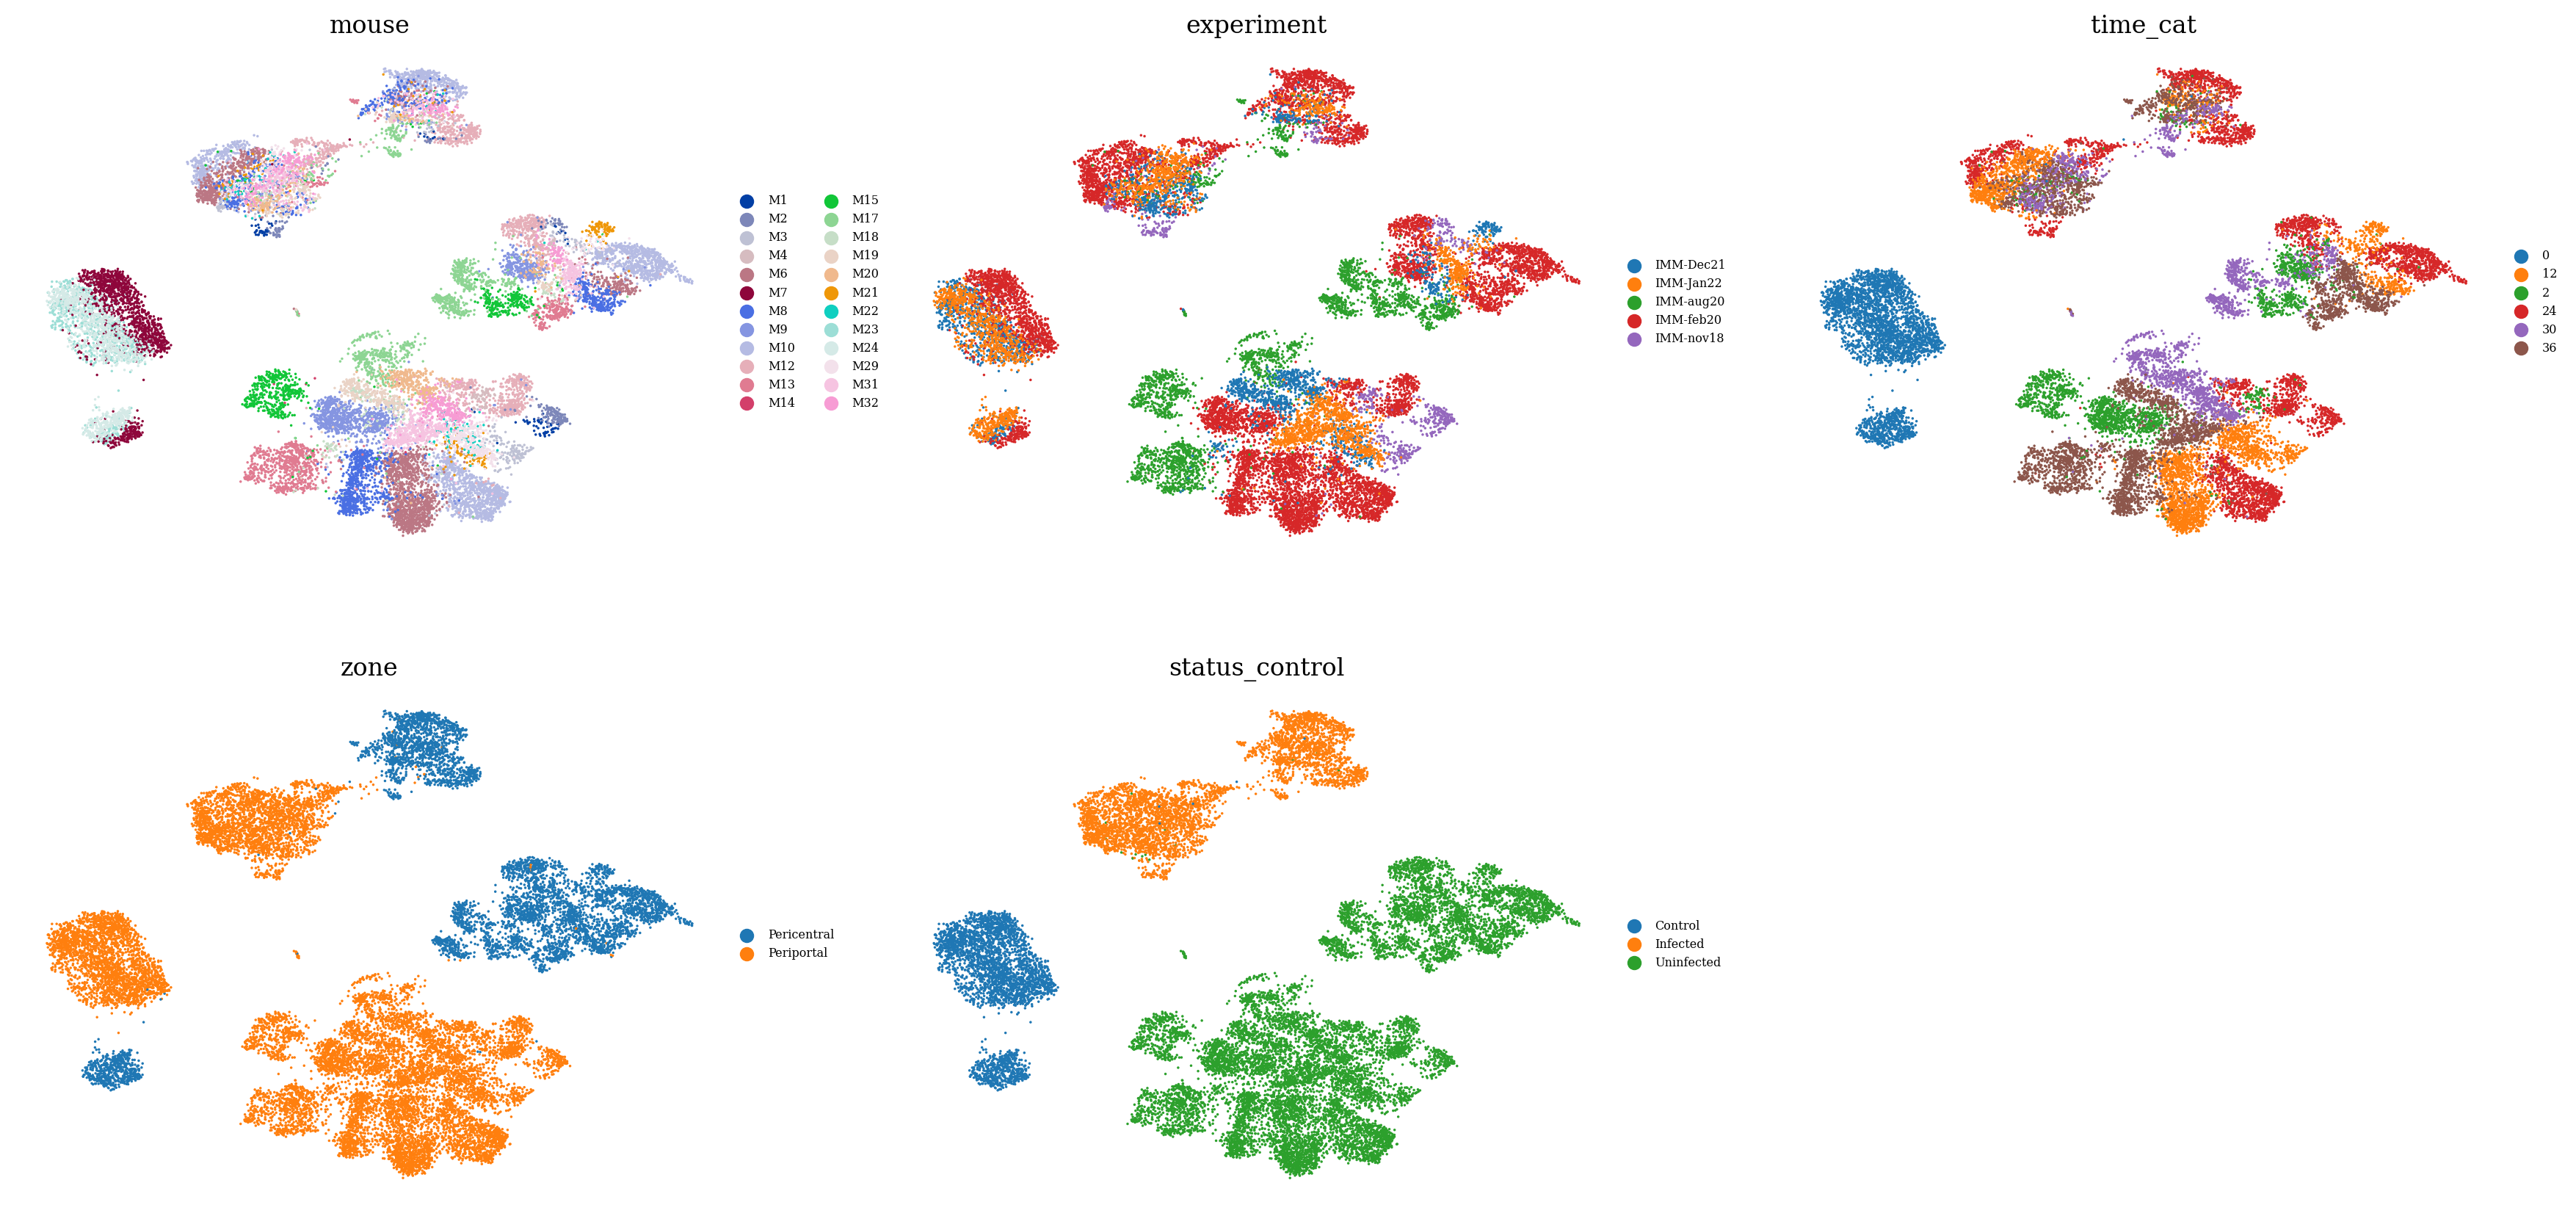

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

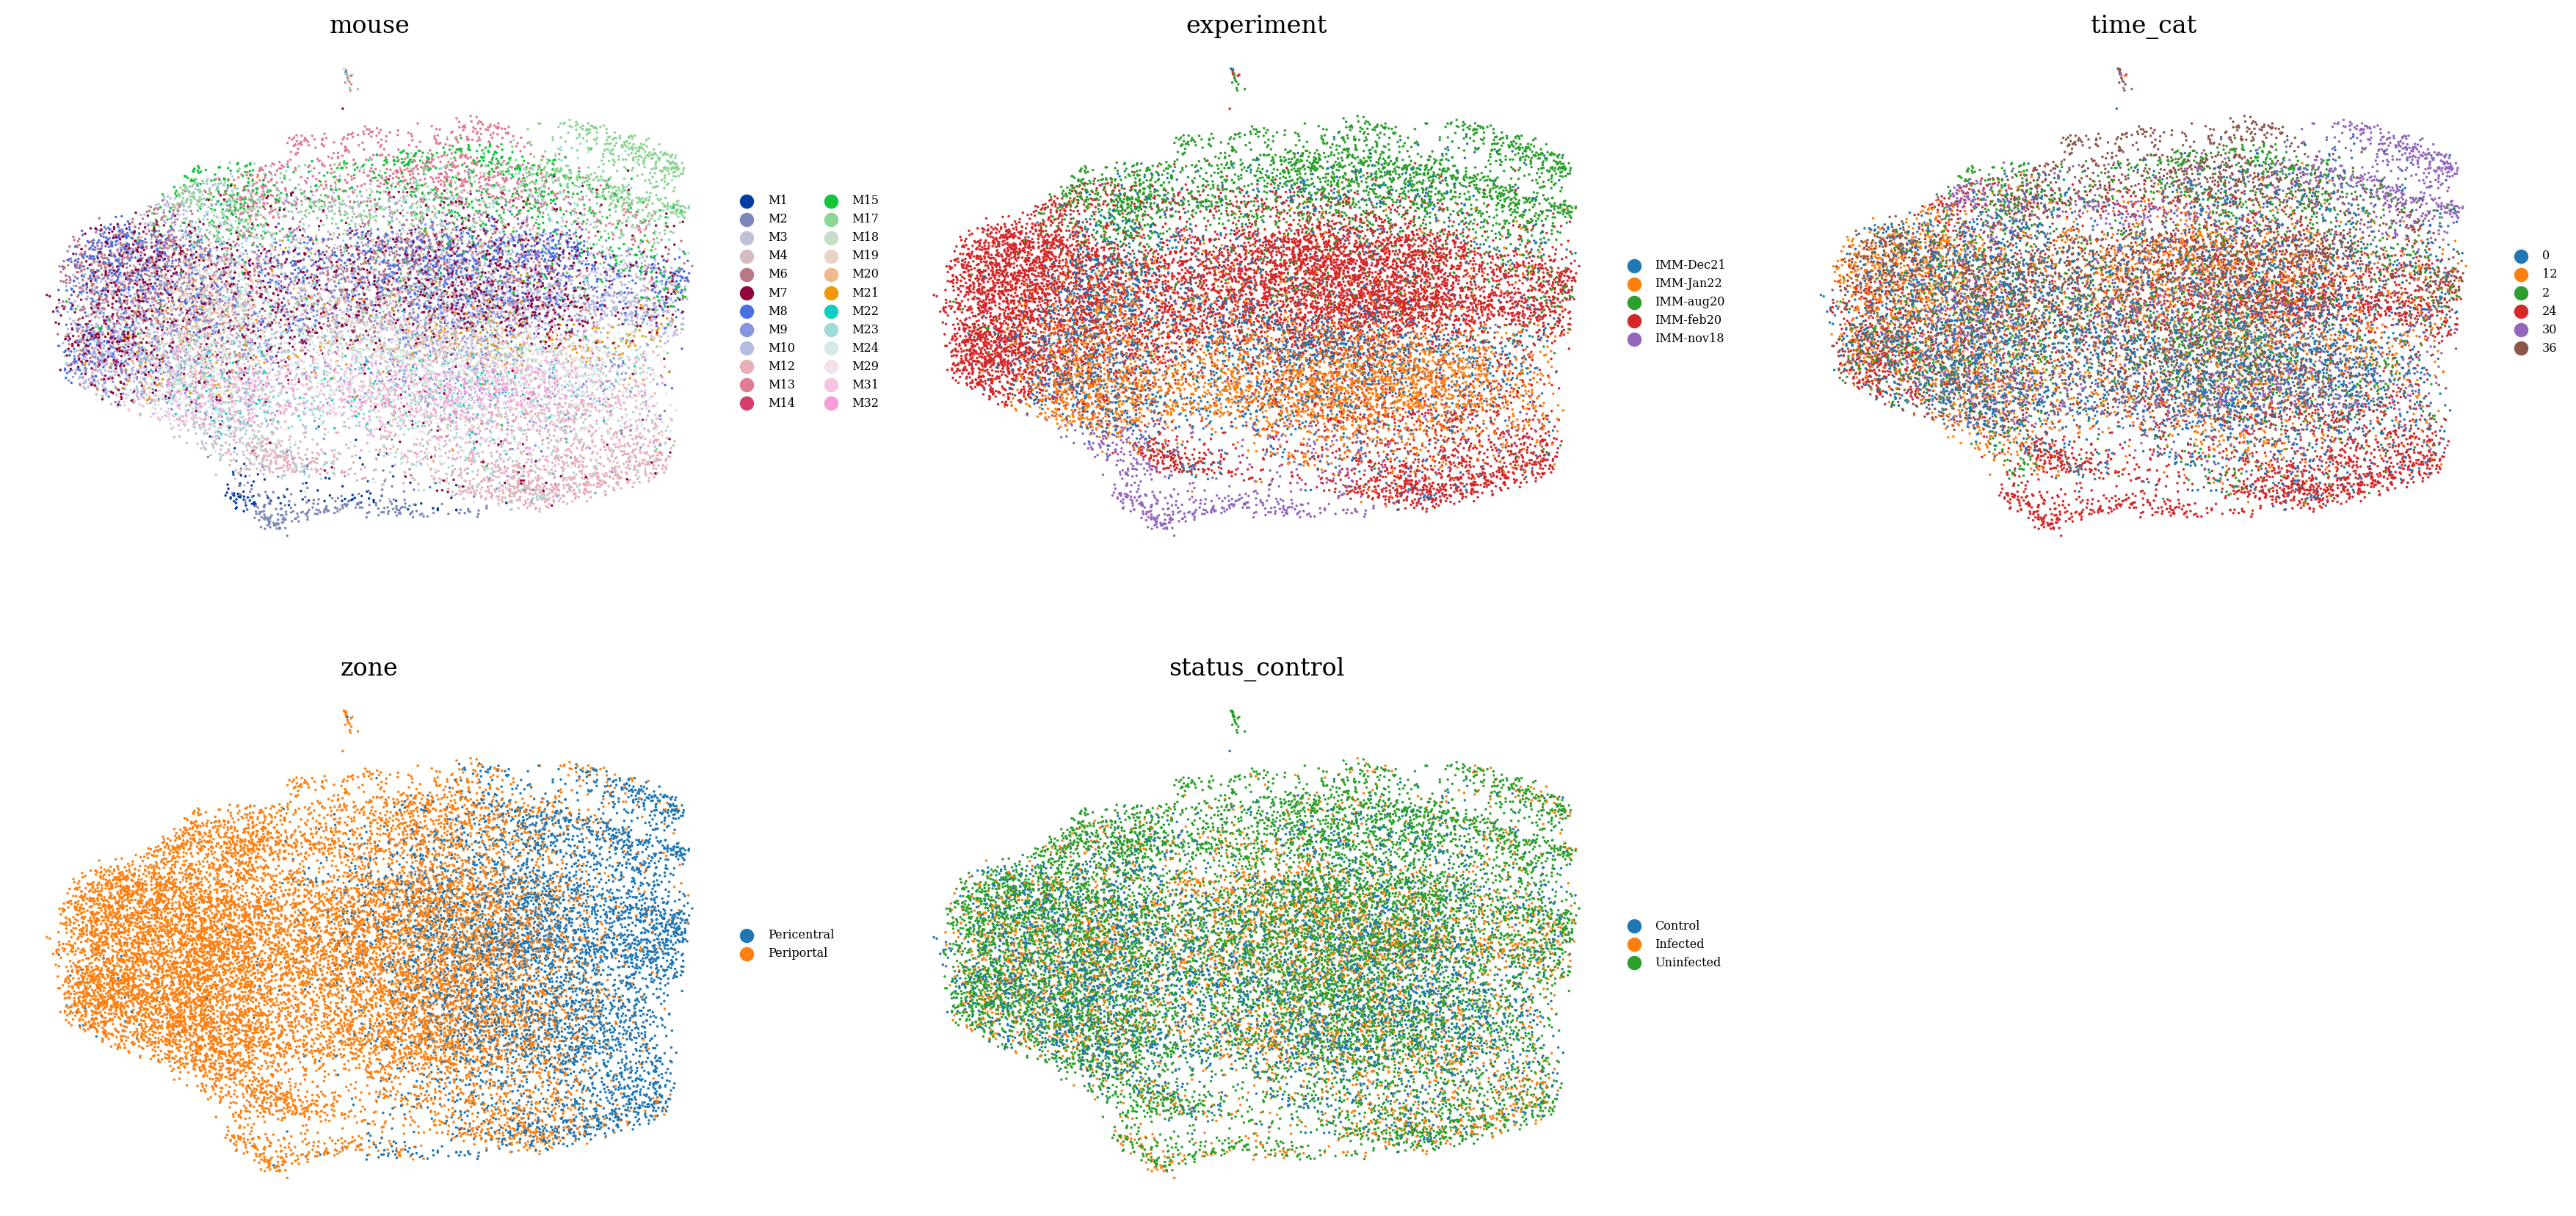

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  0%|          | 1/596 [00:00<02:15,  4.39it/s]

  5%|▍         | 28/596 [00:00<00:05, 105.79it/s]

  9%|▉         | 56/596 [00:00<00:03, 165.80it/s]

 14%|█▍        | 84/596 [00:00<00:02, 202.23it/s]

 19%|█▊        | 111/596 [00:00<00:02, 223.13it/s]

 23%|██▎       | 138/596 [00:00<00:01, 236.14it/s]

 28%|██▊       | 165/596 [00:00<00:01, 245.31it/s]

 32%|███▏      | 192/596 [00:00<00:01, 251.87it/s]

 37%|███▋      | 219/596 [00:01<00:01, 256.38it/s]

 41%|████▏     | 246/596 [00:01<00:01, 259.31it/s]

 46%|████▌     | 273/596 [00:01<00:01, 261.20it/s]

 50%|█████     | 300/596 [00:01<00:01, 262.97it/s]

 55%|█████▍    | 327/596 [00:01<00:01, 263.91it/s]

 59%|█████▉    | 354/596 [00:01<00:00, 264.30it/s]

 64%|██████▍   | 381/596 [00:01<00:00, 263.39it/s]

 68%|██████▊   | 408/596 [00:01<00:00, 263.86it/s]

 73%|███████▎  | 435/596 [00:01<00:00, 264.51it/s]

 78%|███████▊  | 462/596 [00:01<00:00, 265.34it/s]

 82%|████████▏ | 489/596 [00:02<00:00, 266.20it/s]

 87%|████████▋ | 516/596 [00:02<00:00, 266.04it/s]

 91%|█████████ | 543/596 [00:02<00:00, 265.86it/s]

 96%|█████████▌| 570/596 [00:02<00:00, 265.82it/s]

100%|██████████| 596/596 [00:02<00:00, 241.94it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

576

608

608

640

640

672

672

704

704

736

736

768

In [23]:
np.mean(r2s)

0.9777476143918576

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)